# Self interest transactions

This content is part of the following scientific paper: https://people.mpi-sws.org/~johnme/pdf/messias_imc2021_btc_tx_ordering.pdf
```
Selfish & Opaque Transaction Ordering in the Bitcoin Blockchain: The Case for Chain Neutrality. 
Johnnatan Messias, Mohamed Alzayat, Balakrishnan Chandrasekaran, Krishna P. Gummadi, Patrick Loiseau, and Alan Mislove. 2021.
In ACM Internet Measurement Conference (IMC '21), November 2-4, 2021, Virtual Event, USA. ACM, New York, NY, USA, 16 pages.
https://doi.org/10.1145/3487552.3487823
```

## Import useful functions

In [1]:
from utils_plot import *
import pandas as pd
from tqdm.notebook import tqdm
import gzip
from ast import literal_eval
import numpy as np
from scipy.stats import binom
import itertools
pd.set_option('max_colwidth', 10000)

In [2]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor

In [82]:
# File path that contains the Bitcoin data set
data_path = 'data-2020/'

In [3]:
tqdm.pandas()

In [4]:
percentiles = [.01, .05, .1, .2, .25, .50, .75, .8, .9, .95, .99]

In [5]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor

In [6]:
def load_transactions(n_cores=5):
    dfs = list()
    filenames = [data_path+'transactions/' + filename for filename in os.listdir(data_path+'transactions/') if filename.endswith('.csv.gz')]
    with ProcessPoolExecutor(n_cores) as p:
        dfs = list(tqdm(p.map(load_transaction, filenames), desc='Loading files', total=len(filenames)))
    print('Concating dataframes')
    return pd.concat(dfs)

def load_transaction(filename):
    df = read_file(filename)
    df['spends_from'] = df['spends_from'].apply(literal_eval)
    df['vin_addresses'] = df['vin_addresses'].apply(literal_eval)
    df['vout_addresses'] = df['vout_addresses'].apply(literal_eval)
    df['time'] = pd.to_datetime(df['time'])
    df['n_utxo'] = df['n_vout'] - df['n_vin']
    # df['tx_position_percentile'] = (df['tx_position']/df['n_tx']).mul(100).astype(int)
    return df

def read_file(filename, usecols=None, parse_dates=False):
    return pd.read_csv(filename, sep=';', compression='gzip', usecols=usecols, parse_dates=parse_dates)

In [7]:
def get_miners_wallets_from_blocks(df):
    mpo_addresses = dict()
    for index, row in df[['miner', 'addresses']].iterrows():
        if not row['miner'] in mpo_addresses:
            mpo_addresses[row['miner']] = list()
        mpo_addresses[row['miner']] += [address for address in row['addresses']]
    for miner in mpo_addresses:
        mpo_addresses[miner] = list(set(mpo_addresses[miner]))
    return mpo_addresses

## Loading the data set

### Miners

In [8]:
miners_df = read_file(data_path+'miners-610691--663904.csv.gz')
miners_df['addresses'] = miners_df['addresses'].progress_apply(literal_eval)
miners_df['n_addresses'] = miners_df['addresses'].progress_apply(len)
miners_df.shape

  0%|          | 0/53214 [00:00<?, ?it/s]

  0%|          | 0/53214 [00:00<?, ?it/s]

(53214, 5)

In [9]:
miners_df.head()

,block_height,miner,n_tx,addresses,n_addresses
0,610691,Poolin,2500,[1KDf847BWEMwthPHFtvWAfESdQMRnr25f7],1
1,610692,Huobi,1840,[1C81BGyi8SJ919UxnHm2iwNmaN2RHfU4us],1
2,610693,F2Pool,1105,[1KFHE7w8BhaENAswwryaoccDb6qcT6DbYY],1
3,610694,Unknown,982,[3QLeXx1J9Tp3TBnQyHrhVxne9KqkAS9JSR],1
4,610695,AntPool,2881,[12dRugNcdxK39288NjcDV4GX7rMsKCGn6B],1


In [10]:
top_miners = miners_df.miner.value_counts().index

### Blocks

In [11]:
blocks_df = read_file(data_path+'blocks-610691--663904.csv.gz')
blocks_df['time'] = pd.to_datetime(blocks_df['time'])
blocks_df['mediantime'] = pd.to_datetime(blocks_df['mediantime'])
blocks_df.shape

(53214, 18)

In [12]:
blocks_df.columns

Index(['height', 'hash', 'nTx', 'bits', 'size', 'strippedsize', 'weight',
       'vsize', 'time', 'mediantime', 'nonce', 'version', 'chainwork',
       'difficulty', 'merkleroot', 'versionHex', 'nextblockhash',
       'previousblockhash'],
      dtype='object')

In [13]:
blocks_df.head()

,height,hash,nTx,bits,size,strippedsize,weight,vsize,time,mediantime,nonce,version,chainwork,difficulty,merkleroot,versionHex,nextblockhash,previousblockhash
0,610691,00000000000000000001cc49c6ebb2e7546615e1f168161c75d1843257cb233a,2500,1715bcd0,1250129,914500,3993629,998407.25,2020-01-01 00:03:05,2019-12-31 23:07:30,240614342,549453824,00000000000000000000000000000000000000000b517c9e0b7913153c583488,1.29485934e+13,6616c395c80cd1b01704d6a4eb83a96d94c1ee02736c7bff1617abc77c631f89,20c00000,000000000000000000117f1821db8f36e05a70ed9dbffa5ebb0857021f0f2f51,00000000000000000005f0cc9b565336243d08e65f71ba179a33921fb33aeb93
1,610692,000000000000000000117f1821db8f36e05a70ed9dbffa5ebb0857021f0f2f51,1840,1715bcd0,661706,424345,1934741,483685.25,2020-01-01 00:07:32,2019-12-31 23:13:16,2264085561,536870912,00000000000000000000000000000000000000000b518864eb8f9dbe277d9bda,1.29485934e+13,973352f46a24d90c3f6a8e897edf956b1a2924f2c9d126a39b0895cb245a9d23,20000000,00000000000000000014a2d6530192263dffbb1723acc9d5734d9514138a3f0c,00000000000000000001cc49c6ebb2e7546615e1f168161c75d1843257cb233a
2,610693,00000000000000000014a2d6530192263dffbb1723acc9d5734d9514138a3f0c,1105,1715bcd0,436344,284543,1289973,322493.25,2020-01-01 00:13:34,2019-12-31 23:22:50,4185504105,1073733632,00000000000000000000000000000000000000000b51942bcba6286712a3032c,1.29485934e+13,f7f2ae580b932bea05e76f9d89b510bfeb5942e499d9cabe3beb9c9fa8f3fa9c,3fffe000,000000000000000000053ba498a77d2e186a0d530abe5cfc44aad1afe3ad867f,000000000000000000117f1821db8f36e05a70ed9dbffa5ebb0857021f0f2f51
3,610694,000000000000000000053ba498a77d2e186a0d530abe5cfc44aad1afe3ad867f,982,1715bcd0,467181,285676,1324209,331052.25,2020-01-01 00:19:00,2019-12-31 23:37:18,4102308397,1073733632,00000000000000000000000000000000000000000b519ff2abbcb30ffdc86a7e,1.29485934e+13,0fb984cd84240b3c1631e9a6ef7e69def28349a6c0fe0657954231a17104df93,3fffe000,00000000000000000009ae968a937bea55223270e64058a2fea352d73a57fc22,00000000000000000014a2d6530192263dffbb1723acc9d5734d9514138a3f0c
4,610695,00000000000000000009ae968a937bea55223270e64058a2fea352d73a57fc22,2881,1715bcd0,1123752,758667,3399753,849938.25,2020-01-01 00:37:32,2019-12-31 23:41:32,3452559148,545259520,00000000000000000000000000000000000000000b51abb98bd33db8e8edd1d0,1.29485934e+13,c1a7f17dc14bd5191ff75864a3f3242583e0cf642078c0abde6ac8be682d9ec1,20800000,00000000000000000003510b551473f79a7543cfad1ce97a4ad0793882f6442c,000000000000000000053ba498a77d2e186a0d530abe5cfc44aad1afe3ad867f


## Filtering miners and blocks to 2020 data set

In [14]:
print('merging blocks to miners')
miners_df = miners_df.merge(
    blocks_df[['height', 'time', 'nTx']], left_on='block_height', right_on='height', how='left'
).drop(columns=['height', 'n_tx']).rename(columns={'nTx': 'n_tx'})

print('merging miners and blocks')
blocks_df = blocks_df.merge(
    miners_df[['block_height', 'miner']], left_on='height', right_on='block_height', how='left'
).drop(columns=['height'])

merging blocks to miners
merging miners and blocks


In [15]:
miners_df.set_index('time', inplace=True)

In [16]:
miner_stats = pd.DataFrame([miners_df.miner.value_counts(normalize=False), miners_df.miner.value_counts(normalize=True)]).transpose()
miner_stats.columns = ['abs. number', 'fraction']
miner_stats

,abs. number,fraction
F2Pool,9326.0,0.17525463
Poolin,7876.0,0.14800616
BTC.com,6381.0,0.11991205
AntPool,5832.0,0.10959522
Huobi,3990.0,0.07498027
ViaBTC,3596.0,0.06757620
1THash & 58COIN,3252.0,0.06111174
Okex,2569.0,0.04827677
Binance Pool,2393.0,0.04496937
SlushPool,1994.0,0.03747134


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'F2Pool'),
  Text(1, 0, 'Poolin'),
  Text(2, 0, 'BTC.com'),
  Text(3, 0, 'AntPool'),
  Text(4, 0, 'Huobi'),
  Text(5, 0, 'ViaBTC'),
  Text(6, 0, '1THash & 58COIN'),
  Text(7, 0, 'Okex'),
  Text(8, 0, 'Binance Pool'),
  Text(9, 0, 'SlushPool'),
  Text(10, 0, 'Lubian.com'),
  Text(11, 0, 'BTC.TOP'),
  Text(12, 0, 'NovaBlock'),
  Text(13, 0, 'BytePool'),
  Text(14, 0, 'SpiderPool'),
  Text(15, 0, 'BitFury'),
  Text(16, 0, 'E2M & BTC.TOP'),
  Text(17, 0, 'BitDeer'),
  Text(18, 0, 'Buffett'),
  Text(19, 0, 'Bitcoin.com')])

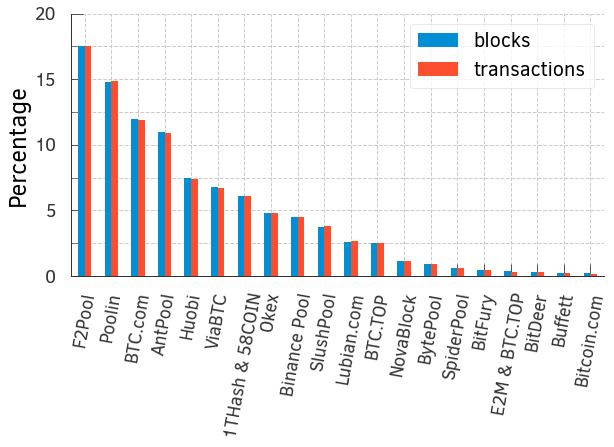

In [17]:
txs_fraction = (100 * (miners_df.groupby('miner').n_tx.sum()/miners_df.n_tx.sum())).sort_values(ascending=False)
blocks_fraction = (100 * miners_df.miner.value_counts(normalize=True))
data = pd.DataFrame([blocks_fraction, txs_fraction]).transpose()
data.drop('Unknown', inplace=True)
data.columns = ['blocks', 'transactions']
ax = data.head(20).plot.bar()
ax.set_ylabel('Percentage')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax.grid(which='minor')
ax.set_ylim((0, 20))
plt.xticks(rotation=80, ha="center")

## Loading Transactions

In [18]:
txs_df = load_transactions(n_cores=cpu_count()-1)
txs_df.shape

Loading files:   0%|          | 0/107 [00:00<?, ?it/s]

Concating dataframes


(112542268, 28)

In [19]:
txs_df.sort_values(by=['block_height', 'tx_position'], inplace=True)

In [20]:
print("set index as time")
txs_df.set_index('time', inplace=True)

set index as time


In [21]:
txs_df.columns

Index(['block_height', 'miner', 'txid', 'is_cpfp', 'is_coinbase',
       'tx_position', 'vin', 'vout', 'n_vin', 'n_vout', 'hash', 'vsize',
       'size', 'fee', 'cfeerate', 'satsize', 'feerate', 'version', 'locktime',
       'n_addresses', 'n_spends_from', 'spends_from', 'n_vin_addresses',
       'n_vout_addresses', 'vin_addresses', 'vout_addresses', 'n_utxo'],
      dtype='object')

In [22]:
txs_df.head()

,block_height,miner,txid,is_cpfp,is_coinbase,tx_position,vin,vout,n_vin,n_vout,...,version,locktime,n_addresses,n_spends_from,spends_from,n_vin_addresses,n_vout_addresses,vin_addresses,vout_addresses,n_utxo
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:03:05,610691,Poolin,e12aadca7a51e816dd804536f6eb140bbf959ce7697626cb9c2a88d33ace5b1f,False,True,0,0.00000000,12.67534026,1,4,...,1,2131434439,1,0,[],0,1,[],"[(1KDf847BWEMwthPHFtvWAfESdQMRnr25f7, 12.67534026)]",3
2020-01-01 00:03:05,610691,Poolin,c425c221200841914c7189d22f21d84616a7809a6aa7a4308a4eab27ae957cbc,False,False,1,1.31800000,1.31573227,1,2,...,1,0,2,1,[ce6435836733787db9f7cc8fd14f5f351c0414d66985f5a2946ca4cecc920ac6],1,2,"[(17z8pewch1CbQvg75uqKP4eo5YQwLapccC, 1.318)]","[(35LN5maPgWjhrKnYcMnwQD5oAoRcdTwNga, 0.5), (1EvL2QhZT9PHvsGaVer9LVkjWrExaGfxpK, 0.81573227)]",1
2020-01-01 00:03:05,610691,Poolin,630a2610828f40c370ce896bb3ba59561e7b0c1abc99452da72d7d896b3d372b,False,False,2,0.00331581,0.00161411,2,2,...,1,0,1,2,"[6f3698c19147cb6fa69a088608b45c29d31009e9f36549b06f21ad5b7903ad38, 9b52b5120a0ef9605f0eec4b4a6b5114cb08c3f6877c63286fc064f409e7a8b8]",2,1,"[(1FGiZB7K757EUixGcyeyME6Jp8qQZEiUUk, 0.00142631), (1FGiZB7K757EUixGcyeyME6Jp8qQZEiUUk, 0.0018895)]","[(1FGiZB7K757EUixGcyeyME6Jp8qQZEiUUk, 0.00161411)]",0
2020-01-01 00:03:05,610691,Poolin,748b26c5570a8c95250817f1a77ba5075769f5e16adb25af92025fe0284abc3e,False,False,3,0.00477006,0.00306836,2,2,...,1,0,1,2,"[77c68719c3be4691438a8325821dffe7911171180f1c8f01dd0438e00dd3caf8, 22ad0ae68de93eb1218ae597bdcab9f4495ca6a072cb7e11eb31f948a9e7140b]",2,1,"[(1JctmVUHHfchRQHR1K1v9E9rs3mSWLGEmt, 0.00231716), (1JctmVUHHfchRQHR1K1v9E9rs3mSWLGEmt, 0.0024529)]","[(1JctmVUHHfchRQHR1K1v9E9rs3mSWLGEmt, 0.00306836)]",0
2020-01-01 00:03:05,610691,Poolin,d126a038ca44a48ce79cc2a67318bf1be5e09b8d9e781d53533d64c0cb125d82,False,False,4,0.00463432,0.00293262,2,2,...,1,0,1,2,"[ec0c923602107f4395fe01051d86febbd1904acc1b9d220020005e98874d5a96, 69851387f4921f4569de06197819db188bc5ed91085cb322f903116785790f4c]",2,1,"[(12tLxUuMAnvh9pXdBSBwxL5VtK68dTbNS3, 0.00231716), (12tLxUuMAnvh9pXdBSBwxL5VtK68dTbNS3, 0.00231716)]","[(12tLxUuMAnvh9pXdBSBwxL5VtK68dTbNS3, 0.00293262)]",0


In [23]:
txs_df.is_coinbase.value_counts()

False    112489054
True         53214
Name: is_coinbase, dtype: int64

## Merging data sets

# Building filtered data set with non-CPFP txs

In [24]:
# Filtering out CPFP-txs and coinbase transactions
non_cpfp_txs_df = txs_df.query('not is_coinbase and not is_cpfp')

In [25]:
non_cpfp_txs_df.shape

(90994433, 27)

In [26]:
txs_df.query('not is_coinbase').is_cpfp.value_counts()

False    90994433
True     21494621
Name: is_cpfp, dtype: int64

## Computing SPPE values

In [27]:
print('Computing tx_position_observed')
non_cpfp_txs_df.loc[:, 'tx_position_observed'] = (non_cpfp_txs_df.groupby("block_height")['tx_position'].rank(method='first', ascending=True).astype(int))

print('Computing tx_position_predicted')
non_cpfp_txs_df.loc[:, 'tx_position_predicted'] = (non_cpfp_txs_df.groupby("block_height")['cfeerate'].rank(method='first', ascending=False).astype(int))

print('Computing rank_percentile_observed')
non_cpfp_txs_df.loc[:, 'rank_percentile_observed'] = (non_cpfp_txs_df.groupby(
    "block_height"
)['tx_position_observed'].rank(method='average', ascending=True, pct=True).mul(100).round(0).astype(int))


print('Computing rank_percentile_predicted')
non_cpfp_txs_df.loc[:, 'rank_percentile_predicted'] = (non_cpfp_txs_df.groupby(
    "block_height"
)['tx_position_predicted'].rank(method='average', ascending=True, pct=True).mul(100).round(0).astype(int))

Computing tx_position_observed


/home/johnme/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Computing tx_position_predicted
Computing rank_percentile_observed
Computing rank_percentile_predicted


In [28]:
# Computing SPPE
non_cpfp_txs_df.loc[:, 'SPPE'] = (non_cpfp_txs_df['rank_percentile_predicted'] - non_cpfp_txs_df['rank_percentile_observed'])

In [29]:
# Computing PPE
non_cpfp_txs_df.loc[:, 'PPE'] = (non_cpfp_txs_df['rank_percentile_predicted'] - non_cpfp_txs_df['rank_percentile_observed']).abs()

In [30]:
non_cpfp_txs_df.columns

Index(['block_height', 'miner', 'txid', 'is_cpfp', 'is_coinbase',
       'tx_position', 'vin', 'vout', 'n_vin', 'n_vout', 'hash', 'vsize',
       'size', 'fee', 'cfeerate', 'satsize', 'feerate', 'version', 'locktime',
       'n_addresses', 'n_spends_from', 'spends_from', 'n_vin_addresses',
       'n_vout_addresses', 'vin_addresses', 'vout_addresses', 'n_utxo',
       'tx_position_observed', 'tx_position_predicted',
       'rank_percentile_observed', 'rank_percentile_predicted', 'SPPE', 'PPE'],
      dtype='object')

In [31]:
non_cpfp_txs_df.head(1)

,block_height,miner,txid,is_cpfp,is_coinbase,tx_position,vin,vout,n_vin,n_vout,...,n_vout_addresses,vin_addresses,vout_addresses,n_utxo,tx_position_observed,tx_position_predicted,rank_percentile_observed,rank_percentile_predicted,SPPE,PPE
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:03:05,610691,Poolin,c425c221200841914c7189d22f21d84616a7809a6aa7a4308a4eab27ae957cbc,False,False,1,1.318,1.31573227,1,2,...,2,"[(17z8pewch1CbQvg75uqKP4eo5YQwLapccC, 1.318)]","[(35LN5maPgWjhrKnYcMnwQD5oAoRcdTwNga, 0.5), (1EvL2QhZT9PHvsGaVer9LVkjWrExaGfxpK, 0.81573227)]",1,1,1,0,0,0,0


In [32]:
non_cpfp_txs_df.block_height.unique().size

52974

count    52974.00000000
mean         2.65025145
std          2.89348231
min          0.00000000
1%           0.00000000
5%           0.14972141
10%          0.31747445
20%          0.59906655
25%          0.76253307
50%          1.77970367
75%          3.47666003
80%          4.03104358
90%          5.95955267
95%          8.22438099
99%         13.79398372
max         40.64459016
Name: PPE, dtype: float64

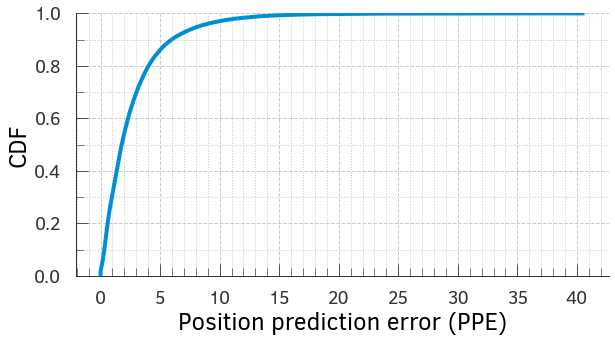

In [33]:
data = non_cpfp_txs_df[['block_height', 'PPE']].groupby('block_height').mean().PPE
ax = plot_cdf(data=data, x_label='Position prediction error (PPE)', y_label='CDF', log=False, interval=None,
             color=None, ax=None, label=None,
             linewidth=None, alpha=1, y_lim=[0, 1], marker=None, markersize=None)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(.1))
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle=':')
data.describe(percentiles=percentiles)

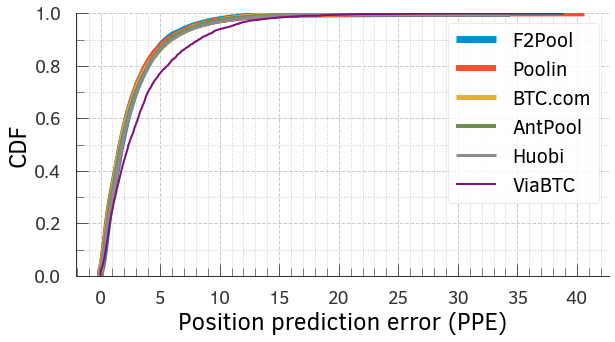

In [34]:
ax = None
linewidth = 7
style = ['solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted']

for miner in top_miners[:6]:
    data = non_cpfp_txs_df.query('miner == @miner')[['block_height', 'PPE']].groupby('block_height').mean().PPE
    ax = plot_cdf(ax=ax, data=data, x_label='Position prediction error (PPE)', y_label='CDF', log=False, interval=None,
                 color=None, label=miner,
                 linewidth=linewidth, linestyle='-', alpha=1, 
                  y_lim=[0, 1], marker=None, markersize=None)
    linewidth-=1
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(.1))
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle=':')
plt.legend()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

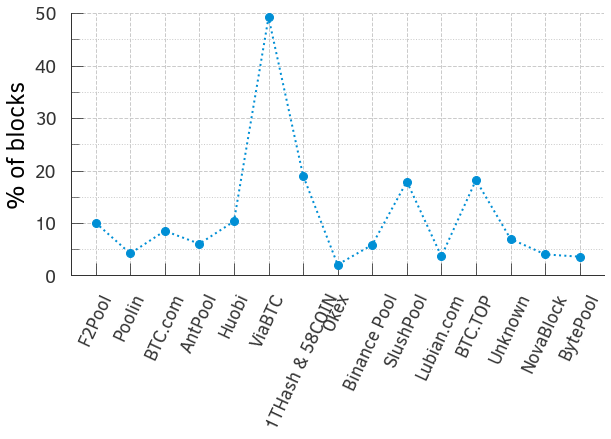

In [35]:
deviation_perc = 99
data = non_cpfp_txs_df.query(f"SPPE >= {deviation_perc}")
data = (100 * (data[['block_height', 'miner']].drop_duplicates().miner.value_counts(normalize=False)/miners_df.miner.value_counts(normalize=False))).round(2)
data = data.loc[top_miners[:15]]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(data.index, data, linewidth=2, linestyle=':', marker='o', markersize=8)
ax.set_ylabel('% of blocks')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_ylim((0, 50))
ax.grid(b=True, which='minor', linestyle=':')
plt.xticks(rotation=65, ha="center")

# Own MPO Wallet analysis

In [36]:
# Get MPOs wallet addresses
mpo_addresses_df = list()
for d in tqdm(get_miners_wallets_from_blocks(df=miners_df).items()):
    mpo_addresses_df += [{'miner': d[0], 'address': x} for x in d[1]]
mpo_addresses_df = pd.DataFrame(mpo_addresses_df)
mpo_addresses_df.shape

  0%|          | 0/31 [00:00<?, ?it/s]

(412, 2)

In [37]:
mpo_addresses_df.head()

,miner,address
0,Poolin,3DRqFYMG2dFpVb8uTpCu8WoBhRBQ2FCphb
1,Poolin,39qbJCDDwycTTkvmHE3qbtta7PhhjrLKTD
2,Poolin,1MWrgo4rm1aoPYFjCCMXgr1e564xVyHCqM
3,Poolin,39PVJ1sEVmFHJXjEG1D8kQa4Mk7f7jeMvA
4,Poolin,39LN9py33ZoMbMscJWGEy2YD8Gbrct55Mm


In [38]:
mpo_addresses_df.query('miner != "Unknown"').shape

(364, 2)

In [39]:
mpo_addresses_df.drop_duplicates().shape

(412, 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'F2Pool'),
  Text(1, 0, 'Poolin'),
  Text(2, 0, 'BTC.com'),
  Text(3, 0, 'AntPool'),
  Text(4, 0, 'Huobi'),
  Text(5, 0, 'ViaBTC'),
  Text(6, 0, '1THash & 58COIN'),
  Text(7, 0, 'Okex'),
  Text(8, 0, 'Binance Pool'),
  Text(9, 0, 'SlushPool'),
  Text(10, 0, 'Lubian.com'),
  Text(11, 0, 'BTC.TOP'),
  Text(12, 0, 'NovaBlock'),
  Text(13, 0, 'BytePool'),
  Text(14, 0, 'SpiderPool'),
  Text(15, 0, 'BitFury'),
  Text(16, 0, 'E2M & BTC.TOP'),
  Text(17, 0, 'BitDeer'),
  Text(18, 0, 'Buffett'),
  Text(19, 0, 'Bitcoin.com')])

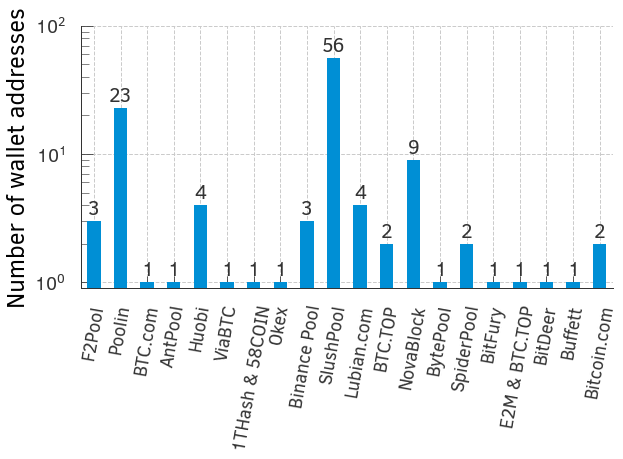

In [40]:
data = mpo_addresses_df.query('miner != "Unknown"')
top_miners_ = [miner for miner in top_miners if miner != 'Unknown']
ax = data.miner.value_counts(normalize=False).loc[top_miners_[:20]].plot.bar()
autolabel(ax.patches, precision=0)
ax.set_ylabel('Number of wallet addresses')
ax.set_yscale('log')
ax.set_ylim((0.9, 100))
plt.xticks(rotation=80)

In [41]:
mpo_addresses_df.query('miner == "BitDeer"')

,miner,address
405,BitDeer,bc1qjl8uwezzlech723lpnyuza0h2cdkvxvh54v3dn


In [42]:
mpo_addresses_df.query('miner == "Buffett"')

,miner,address
396,Buffett,34Jpa4Eu3ApoPVUKNTN2WeuXVVq1jzxgPi


In [43]:
mpo_addresses = set(mpo_addresses_df.query('miner != "Unknown"').address.unique().tolist())
len(mpo_addresses)

361

In [44]:
def get_matrix_addresses(mpo_addresses_df, addresses, miners):
    matrix_dict = dict()
    for miner_a in miners:
        matrix_dict[miner_a] = {}
        for miner_b in miners:
            matrix_dict[miner_a][miner_b] = 0
    for address in tqdm(addresses):
        pairs_ = itertools.combinations(mpo_addresses_df.query('address == @address').miner, 2)
        for pair_ in pairs_:
            matrix_dict[pair_[0]][pair_[1]] += 1
            matrix_dict[pair_[1]][pair_[0]] += 1
    return pd.DataFrame(matrix_dict)

In [45]:
addresses = mpo_addresses_df.address.unique()
miners = miners_df.miner.unique()
matrix_df = get_matrix_addresses(mpo_addresses_df, addresses, miners)
mpo_addresses_df.head()

  0%|          | 0/400 [00:00<?, ?it/s]

,miner,address
0,Poolin,3DRqFYMG2dFpVb8uTpCu8WoBhRBQ2FCphb
1,Poolin,39qbJCDDwycTTkvmHE3qbtta7PhhjrLKTD
2,Poolin,1MWrgo4rm1aoPYFjCCMXgr1e564xVyHCqM
3,Poolin,39PVJ1sEVmFHJXjEG1D8kQa4Mk7f7jeMvA
4,Poolin,39LN9py33ZoMbMscJWGEy2YD8Gbrct55Mm


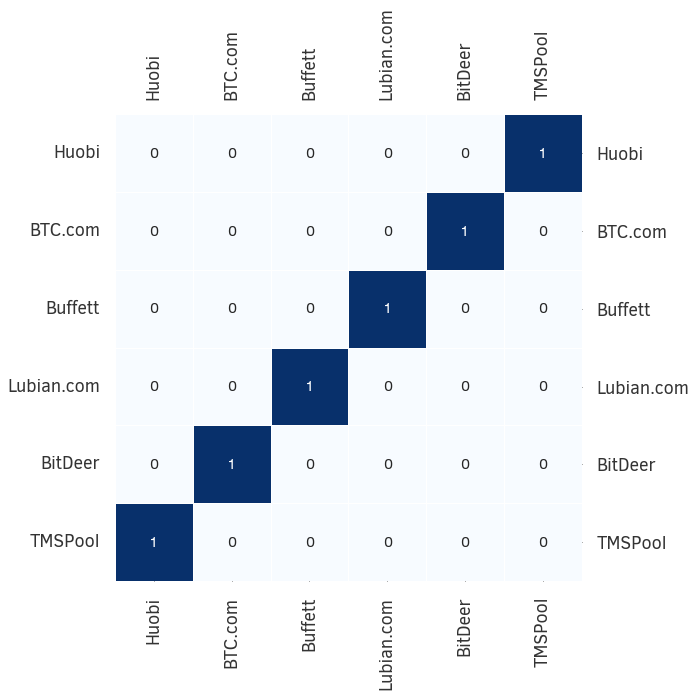

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix_df[matrix_df != 0].drop(columns='Unknown', index='Unknown').dropna(axis=1, how='all').dropna(axis=0, how='all').fillna(0), 
            ax=ax, cmap="Blues", annot=True, cbar=False, linewidths=.5, square=True,
            fmt='g', vmin=0, vmax=1, annot_kws={"size": 15}, cbar_kws={"shrink": .5})

ax.tick_params(axis='x', labelrotation=90, labeltop=True, top=True)
ax.tick_params(axis='y', labelrotation=0, labelright=True, right=True)

In [47]:
excluding_miners = ['Unknown', 'BitDeer', 'TMSPool', 'Buffett']
addresses_dict = mpo_addresses_df.query('miner not in @excluding_miners').set_index('address').to_dict()['miner']

In [ ]:
txs_df.query('not is_cpfp and not is_coinbase').shape

(90994433, 27)

In [ ]:
def check_mpo_txs(df, addresses_dict):
    mpo_df = list()
    for _, row in tqdm(df.iterrows(), desc="Checking for MPOs txs", total=df.shape[0]):
        mpo = set()
        for addr_ in row['vin_addresses']:
            if addr_[0] in addresses_dict:
                mpo.add(addresses_dict[addr_[0]])
        for addr_ in row['vout_addresses']:
            if addr_[0] in addresses_dict:
                mpo.add(addresses_dict[addr_[0]])
        mpo_df.append({
            'block_height': row['block_height'], 'txid': row['txid'], 'miner': row['miner'], 
            'mpo_owner': ','.join(mpo) if mpo else np.nan, 'is_mpo_owner': len(mpo) != 0, 
            'is_cpfp': row['is_cpfp'], 'is_coinbase': row['is_coinbase']
        })
    print('Generating dataframe')
    return pd.DataFrame(mpo_df)

In [50]:
mpo_df = check_mpo_txs(df=txs_df, addresses_dict=addresses_dict)
mpo_df.shape

Checking for MPOs txs:   0%|          | 0/112542268 [00:00<?, ?it/s]

Generating dataframe


(112542268, 7)

In [51]:
mpo_df.head()

,block_height,txid,miner,mpo_owner,is_mpo_owner,is_cpfp,is_coinbase
0,610691,e12aadca7a51e816dd804536f6eb140bbf959ce7697626cb9c2a88d33ace5b1f,Poolin,Poolin,True,False,True
1,610691,c425c221200841914c7189d22f21d84616a7809a6aa7a4308a4eab27ae957cbc,Poolin,NaN,False,False,False
2,610691,630a2610828f40c370ce896bb3ba59561e7b0c1abc99452da72d7d896b3d372b,Poolin,NaN,False,False,False
3,610691,748b26c5570a8c95250817f1a77ba5075769f5e16adb25af92025fe0284abc3e,Poolin,NaN,False,False,False
4,610691,d126a038ca44a48ce79cc2a67318bf1be5e09b8d9e781d53533d64c0cb125d82,Poolin,NaN,False,False,False


In [52]:
mpo_df.columns

Index(['block_height', 'txid', 'miner', 'mpo_owner', 'is_mpo_owner', 'is_cpfp',
       'is_coinbase'],
      dtype='object')

In [53]:
mpo_df.query('not is_coinbase').is_mpo_owner.value_counts()

False    112472643
True         16411
Name: is_mpo_owner, dtype: int64

In [54]:
100 * mpo_df.query('not is_coinbase').is_mpo_owner.value_counts(normalize=True)

False    99.98541102
True      0.01458898
Name: is_mpo_owner, dtype: float64

In [55]:
mpo_df.query('not is_coinbase and is_mpo_owner')[['block_height', 'miner']].drop_duplicates().miner.value_counts()

F2Pool             2155
Poolin             1635
BTC.com            1349
ViaBTC             1180
AntPool            1157
Huobi               802
1THash & 58COIN     794
Okex                579
SlushPool           576
Binance Pool        397
BTC.TOP             344
Lubian.com          268
Unknown             142
NovaBlock           117
BytePool            115
BitFury              65
SpiderPool           59
E2M & BTC.TOP        42
Buffett              27
Bitcoin.com          23
BitDeer              20
Taal                 17
OKKONG               17
CKPool               12
SigmaPool             9
BTCPool               8
TMSPool               5
KanoPool              1
SBICrypto             1
PooIn.com             1
Name: miner, dtype: int64

In [56]:
mpo_df.query('not is_coinbase').mpo_owner.value_counts().sum()

16411

In [57]:
mpo_owner = mpo_df.query('not is_coinbase and is_mpo_owner')
mpo_owner.shape

(16411, 7)

In [58]:
mpo_owner.mpo_owner

2544                       SlushPool
3165                          ViaBTC
12860                          Huobi
13519                        BTC.com
19965                     SpiderPool
                      ...           
112469950    1THash & 58COIN,BTC.TOP
112472644                     ViaBTC
112472646                     ViaBTC
112483597                 Lubian.com
112517923                     ViaBTC
Name: mpo_owner, Length: 16411, dtype: object

In [59]:
mpo_owner.loc[:, 'n_mpo_owner'] = mpo_owner.mpo_owner.progress_apply(lambda x: len(x.split(',')))

  0%|          | 0/16411 [00:00<?, ?it/s]

/home/johnme/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [60]:
mpo_owner = mpo_owner.merge(txs_df[
    ['txid', 'tx_position', 'vin', 'vout', 'n_vin', 'n_vout',
    'hash', 'vsize', 'size', 'fee', 'cfeerate', 'satsize',
       'feerate', 'version', 'locktime', 'n_addresses', 'n_spends_from',
       'spends_from', 'n_vin_addresses',
       'n_vout_addresses', 'vin_addresses', 'vout_addresses', 'n_utxo']
], left_on='txid', right_on='txid', how='left')

In [61]:
mpo_owner.shape

(16411, 30)

In [62]:
mpo_owner.n_mpo_owner.value_counts()

1    15378
2      975
3       58
Name: n_mpo_owner, dtype: int64

In [63]:
mpo_owner.query('n_mpo_owner > 1')[
    ['txid', 'tx_position', 'vin', 'vout', 'n_vin', 'n_vout',
    'hash', 'vsize', 'size', 'fee', 'cfeerate', 'satsize',
    'feerate', 'version', 'locktime', 'n_addresses', 'n_spends_from',
    'n_vin_addresses', 'n_vout_addresses', 'n_utxo']
]

,txid,tx_position,vin,vout,n_vin,n_vout,hash,vsize,size,fee,cfeerate,satsize,feerate,version,locktime,n_addresses,n_spends_from,n_vin_addresses,n_vout_addresses,n_utxo
17,5a19f1b58ea207702e7ad3321b946b1c9ae864817534699796a142c47b2f0714,1,164.69088216,164.69068201,10,523,5a19f1b58ea207702e7ad3321b946b1c9ae864817534699796a142c47b2f0714,19056,19056,0.00020015,1050,1.05032536,0.00001050,2,610722,523,10,10,523,513
37,a44329e2e1875abdd909f90edb3e695eab5caf7fced5ff5952d4c1e7ec5379d7,80,18.87248417,18.86745117,4,598,9dd51d0f0477e50f329b14e01cfbb657c6c7a8aa2a889f569f7309a2648509da,20132,20375,0.00503300,25000,25.00000000,0.00025000,2,610837,598,4,4,598,594
67,8ce2433e16e59facbd5dc1dc89bcf3cee9c66dde37be11a19409856091bd0e51,2972,176.47558175,176.47554120,22,13,8ce2433e16e59facbd5dc1dc89bcf3cee9c66dde37be11a19409856091bd0e51,3854,3854,0.00004055,1052,1.05215361,0.00001052,2,610899,13,22,22,13,-9
74,7a125b6f66ede8fbb6b0bd9840cb12cfd483cf52a75cdab58986ff61e3c79d25,1686,12.56794253,12.56491678,1,362,7a125b6f66ede8fbb6b0bd9840cb12cfd483cf52a75cdab58986ff61e3c79d25,12103,12103,0.00302575,25000,25.00000000,0.00025000,2,610921,362,1,1,362,361
107,79afb76fd8ff1b31daf74272aad5a283d0f768c29e145a36fd1dae8a0999a48a,1758,232.14689392,232.14668986,22,461,79afb76fd8ff1b31daf74272aad5a283d0f768c29e145a36fd1dae8a0999a48a,18887,18887,0.00020406,1080,1.08042569,0.00001080,2,611057,461,22,22,461,439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16348,4fb65b58bdc92060919a1e2b18c8f73d9c7067d020a7c92a32e92f0b6f79b50f,8,94.16515689,94.16512007,11,30,4fb65b58bdc92060919a1e2b18c8f73d9c7067d020a7c92a32e92f0b6f79b50f,2724,2724,0.00003682,1351,1.35168869,0.00001352,2,663620,30,11,11,30,19
16363,553d2b1fd68667736c4d91802d7a75f1e18494e03377783c3a3503f2a2147d54,6,35.66512846,35.66508594,5,88,553d2b1fd68667736c4d91802d7a75f1e18494e03377783c3a3503f2a2147d54,3695,3695,0.00004252,1150,1.15074425,0.00001151,2,663653,88,5,5,88,83
16382,c398378f06938674fae3849f8338eccd07a4b8f23517ab7e89943ecfd6a6ce22,290,73.73181411,73.73011588,11,1,c398378f06938674fae3849f8338eccd07a4b8f23517ab7e89943ecfd6a6ce22,1662,1662,0.00169823,102179,102.17990373,0.00102180,1,99999,1,11,11,1,-10
16395,e3fa29dc4c7008bd65eb88105b15a3f378beca0c0738b79ffa5b88e98367fd59,1271,78.89896876,78.89858740,11,26,e3fa29dc4c7008bd65eb88105b15a3f378beca0c0738b79ffa5b88e98367fd59,2525,2525,0.00038136,15103,15.10336634,0.00015103,2,663782,26,11,11,26,15


In [64]:
mpo_owner.mpo_owner.value_counts().sum()

16411

In [65]:
mpo_df.mpo_owner.value_counts()

F2Pool                                   10378
Poolin                                   10110
BTC.com                                   6990
AntPool                                   6098
Huobi                                     5715
Okex                                      4658
ViaBTC                                    4329
SlushPool                                 3601
1THash & 58COIN                           3457
CKPool                                    3258
Binance Pool                              2454
Lubian.com                                1581
BTC.TOP                                   1399
NovaBlock                                  996
SpiderPool                                 901
BytePool                                   628
E2M & BTC.TOP                              575
1THash & 58COIN,BTC.TOP                    457
BitFury                                    370
CKPool,SlushPool                           238
OKKONG                                     149
Bitcoin.com  

In [66]:
mpo_owner.query('n_mpo_owner > 1').mpo_owner.value_counts()

1THash & 58COIN,BTC.TOP                  457
CKPool,SlushPool                         238
Okex,NovaBlock                            83
Poolin,NovaBlock                          59
1THash & 58COIN,Bitcoin.com,BTC.TOP       39
BTC.com,Binance Pool                      36
BTC.com,OKKONG                            31
SpiderPool,BTC.com                        28
BTC.com,SigmaPool                         16
BTC.TOP,1THash & 58COIN,Bitcoin.com       15
1THash & 58COIN,Bitcoin.com               12
SpiderPool,OKKONG                          3
KanoPool,CKPool                            3
E2M & BTC.TOP,1THash & 58COIN,BTC.TOP      3
BTC.TOP,Bitcoin.com                        1
Huobi,1THash & 58COIN,BTC.TOP              1
SlushPool,Okex                             1
SpiderPool,SigmaPool                       1
SpiderPool,Binance Pool                    1
Poolin,BTC.TOP                             1
BTC.com,Huobi                              1
Bitcoin.com,BTC.TOP                        1
SpiderPool

In [67]:
mpo_owner.query('n_mpo_owner == 1').mpo_owner.value_counts()

CKPool             3209
Poolin             2232
Okex               2089
Huobi              1666
SlushPool          1607
F2Pool             1052
ViaBTC              733
SpiderPool          572
BTC.com             445
NovaBlock           399
E2M & BTC.TOP       380
AntPool             266
1THash & 58COIN     205
BytePool            142
BitFury             107
Lubian.com           85
Binance Pool         61
BTC.TOP              46
Bitcoin.com          34
Taal                 14
Foundry              13
SigmaPool             5
BTCPool               5
PooIn.com             5
OKKONG                3
SBICrypto             2
KanoPool              1
Name: mpo_owner, dtype: int64

In [68]:
mpo_owner.query('mpo_owner == "BitDeer"').head()

,block_height,txid,miner,mpo_owner,is_mpo_owner,is_cpfp,is_coinbase,n_mpo_owner,tx_position,vin,...,version,locktime,n_addresses,n_spends_from,spends_from,n_vin_addresses,n_vout_addresses,vin_addresses,vout_addresses,n_utxo


In [69]:
mpo_owner.mpo_owner.value_counts(dropna=False)

CKPool                                   3209
Poolin                                   2232
Okex                                     2089
Huobi                                    1666
SlushPool                                1607
F2Pool                                   1052
ViaBTC                                    733
SpiderPool                                572
1THash & 58COIN,BTC.TOP                   457
BTC.com                                   445
NovaBlock                                 399
E2M & BTC.TOP                             380
AntPool                                   266
CKPool,SlushPool                          238
1THash & 58COIN                           205
BytePool                                  142
BitFury                                   107
Lubian.com                                 85
Okex,NovaBlock                             83
Binance Pool                               61
Poolin,NovaBlock                           59
BTC.TOP                           

In [70]:
mpo_owner.query('n_mpo_owner == 1 and is_mpo_owner').mpo_owner.value_counts(normalize=False) 

CKPool             3209
Poolin             2232
Okex               2089
Huobi              1666
SlushPool          1607
F2Pool             1052
ViaBTC              733
SpiderPool          572
BTC.com             445
NovaBlock           399
E2M & BTC.TOP       380
AntPool             266
1THash & 58COIN     205
BytePool            142
BitFury             107
Lubian.com           85
Binance Pool         61
BTC.TOP              46
Bitcoin.com          34
Taal                 14
Foundry              13
SigmaPool             5
BTCPool               5
PooIn.com             5
OKKONG                3
SBICrypto             2
KanoPool              1
Name: mpo_owner, dtype: int64

In [71]:
mpo_owner.is_coinbase.value_counts()

False    16411
Name: is_coinbase, dtype: int64

In [72]:
data.loc[[miner for miner in top_miners if miner in data.index][:18]].sum()

miner      0.0
address    0.0
dtype: float64

/home/johnme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'F2Pool'),
  Text(1, 0, 'Poolin'),
  Text(2, 0, 'BTC.com'),
  Text(3, 0, 'AntPool'),
  Text(4, 0, 'Huobi'),
  Text(5, 0, 'ViaBTC'),
  Text(6, 0, '1THash & 58COIN'),
  Text(7, 0, 'Okex'),
  Text(8, 0, 'Binance Pool'),
  Text(9, 0, 'SlushPool'),
  Text(10, 0, 'Lubian.com'),
  Text(11, 0, 'BTC.TOP'),
  Text(12, 0, 'NovaBlock'),
  Text(13, 0, 'BytePool'),
  Text(14, 0, 'SpiderPool'),
  Text(15, 0, 'BitFury'),
  Text(16, 0, 'E2M & BTC.TOP'),
  Text(17, 0, 'Bitcoin.com')])

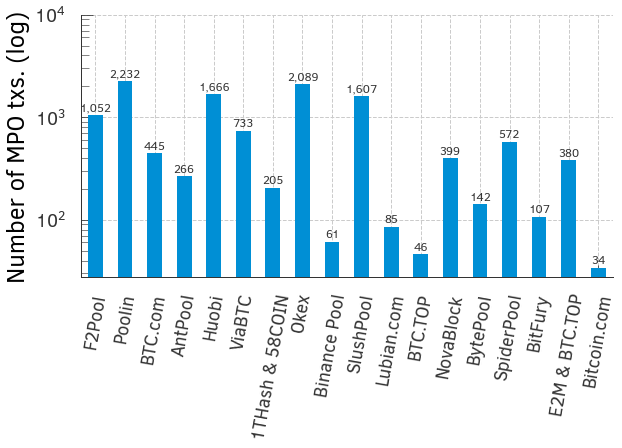

In [73]:
data = mpo_owner.query('n_mpo_owner == 1 and is_mpo_owner').mpo_owner.value_counts(normalize=False)  

ax = data.loc[[miner for miner in top_miners if miner in data.index][:18]].plot.bar()
autolabel(ax.patches, precision=0, fontsize=12)
ax.set_ylabel('Number of MPO txs. (log)')
ax.set_yscale('log')
ax.set_ylim((0, 10000))
plt.xticks(rotation=80)

In [74]:
data.loc[[miner for miner in top_miners if miner in data.index][:18]].max()

2232

In [75]:
mpo_owner.query('is_mpo_owner and miner == mpo_owner and n_mpo_owner == 1').mpo_owner.value_counts(normalize=False).sum()

1927

In [76]:
mpo_owner.query('is_mpo_owner and miner == mpo_owner and n_mpo_owner == 1').mpo_owner.value_counts(normalize=False) 

F2Pool             525
ViaBTC             424
SlushPool          326
Poolin             288
Okex               111
Huobi               90
BTC.com             67
1THash & 58COIN     41
AntPool             23
BitFury              9
Binance Pool         6
CKPool               3
BytePool             3
NovaBlock            3
SpiderPool           3
E2M & BTC.TOP        2
BTC.TOP              1
Lubian.com           1
PooIn.com            1
Name: mpo_owner, dtype: int64

In [77]:
mpo_owner.is_cpfp.value_counts()

False    15340
True      1071
Name: is_cpfp, dtype: int64

## Transactions

Miner of the block,F2Pool,Poolin,BTC.com,AntPool,Huobi,ViaBTC,1THash & 58COIN,Okex,Binance Pool,SlushPool,...,Bitcoin.com,OKKONG,Taal,BTCPool,CKPool,SigmaPool,TMSPool,PooIn.com,SBICrypto,KanoPool
Transaction issuer,,,,,,,,,,,,,,,,,,,,,
F2Pool,525.0,92.0,85.0,71.0,43.0,30.0,34.0,38.0,30.0,24.0,...,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
Poolin,382.0,288.0,296.0,224.0,195.0,165.0,137.0,96.0,146.0,67.0,...,0.0,9.0,0.0,1.0,0.0,5.0,1.0,0.0,1.0,1.0
BTC.com,68.0,58.0,67.0,50.0,28.0,32.0,34.0,16.0,25.0,10.0,...,1.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AntPool,49.0,41.0,34.0,23.0,24.0,14.0,14.0,15.0,7.0,13.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Huobi,298.0,286.0,209.0,156.0,90.0,132.0,127.0,103.0,53.0,63.0,...,2.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
ViaBTC,55.0,46.0,38.0,48.0,26.0,424.0,15.0,16.0,11.0,15.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1THash & 58COIN,19.0,16.0,12.0,17.0,17.0,34.0,41.0,6.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Okex,362.0,339.0,254.0,228.0,136.0,141.0,130.0,111.0,61.0,87.0,...,9.0,4.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0
Binance Pool,12.0,6.0,7.0,11.0,3.0,4.0,5.0,1.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


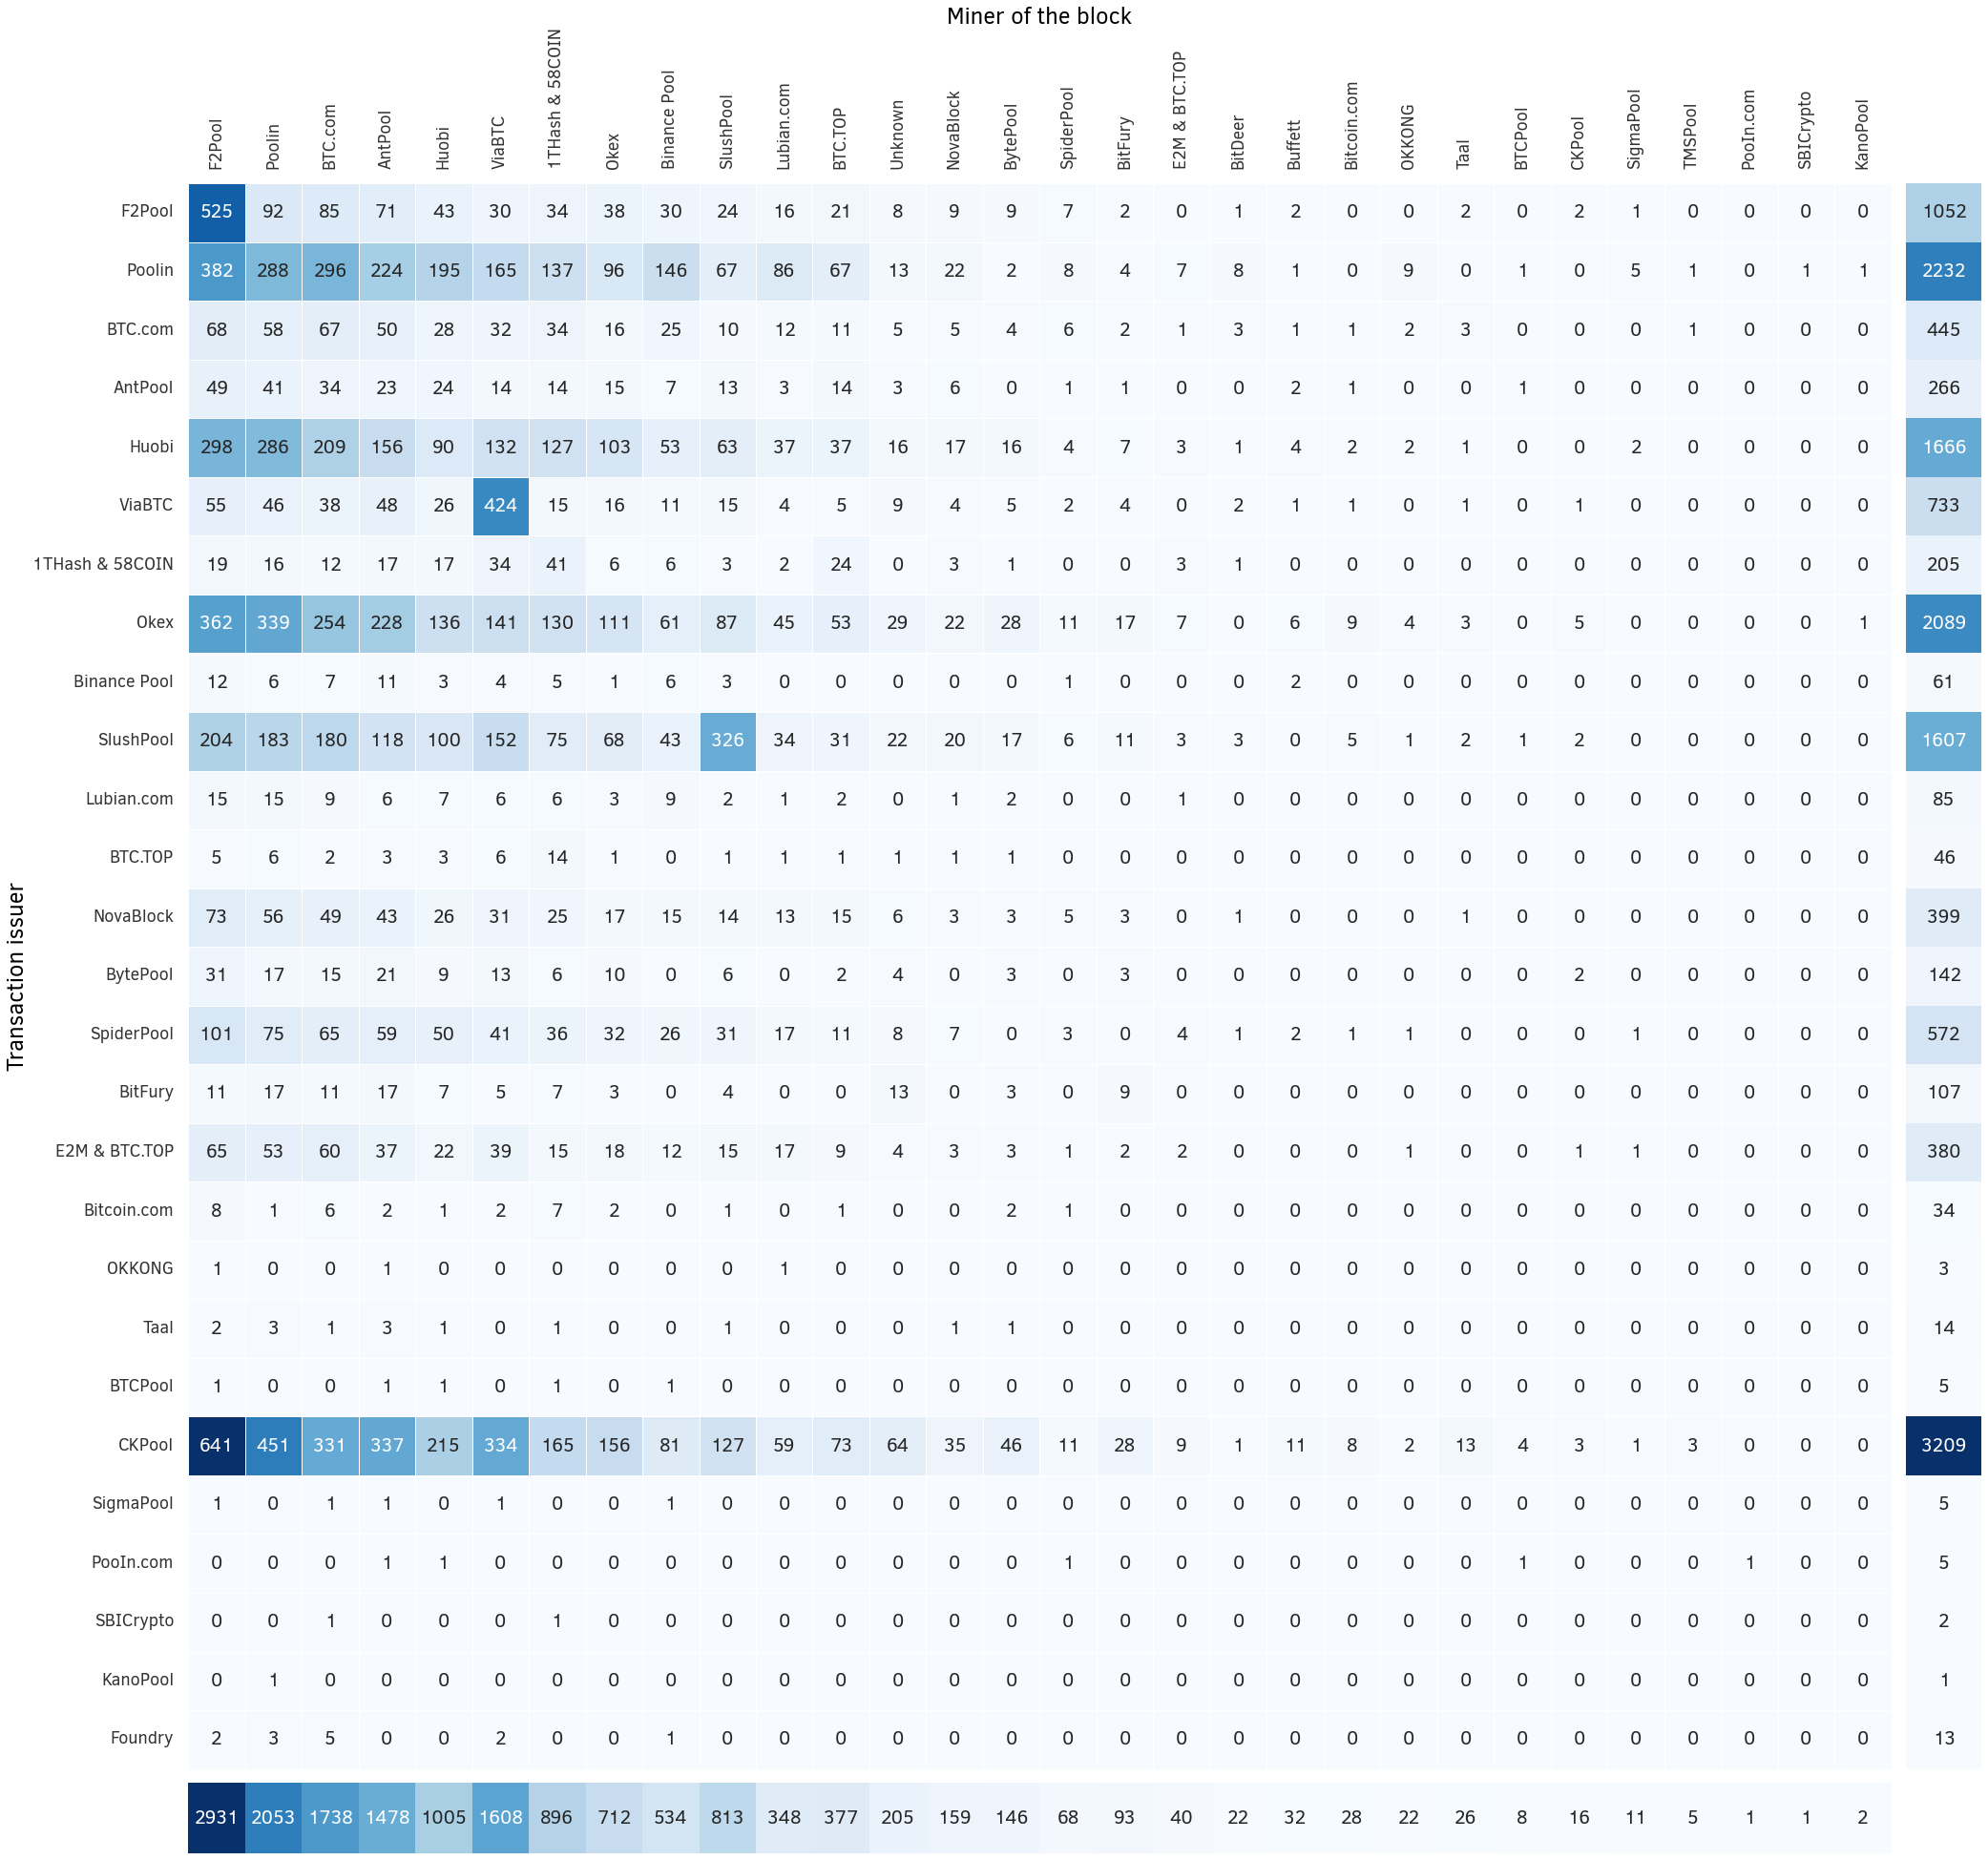

In [78]:
data = mpo_owner.query('is_mpo_owner and n_mpo_owner == 1')[['block_height', 'miner', 'mpo_owner']].groupby(['miner', 'mpo_owner']).size().to_frame().reset_index()
data.columns = ['Miner of the block', 'Transaction issuer', 'amount']

d = data.pivot("Transaction issuer", "Miner of the block", "amount").fillna(0)
d = d.loc[[miner for miner in top_miners if miner in d.index]][[miner for miner in top_miners if miner in d.columns]]

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot2grid((20, 20), (0, 0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((20, 20), (19, 0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20, 20), (0, 19), colspan=1, rowspan=19)
sns.heatmap(d, ax=ax1, annot=True, cmap="Blues", cbar=False, linewidths=.5,fmt='g')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xticklabels(d.columns,rotation=90)

sns.heatmap((pd.DataFrame(d.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, fmt='g')
sns.heatmap(pd.DataFrame(d.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, fmt='g')

#ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_ylabel('')
d

Miner of the block,F2Pool,Poolin,BTC.com,AntPool,Huobi,ViaBTC,1THash & 58COIN,Okex,Binance Pool,SlushPool,...,Bitcoin.com,OKKONG,Taal,BTCPool,CKPool,SigmaPool,TMSPool,PooIn.com,SBICrypto,KanoPool
Transaction issuer,,,,,,,,,,,,,,,,,,,,,
F2Pool,49.90494297,8.74524715,8.07984791,6.74904943,4.08745247,2.85171103,3.23193916,3.61216730,2.85171103,2.28136882,...,0.00000000,0.00000000,0.19011407,0.00000000,0.19011407,0.09505703,0.00000000,0.0,0.00000000,0.00000000
Poolin,17.11469534,12.90322581,13.26164875,10.03584229,8.73655914,7.39247312,6.13799283,4.30107527,6.54121864,3.00179211,...,0.00000000,0.40322581,0.00000000,0.04480287,0.00000000,0.22401434,0.04480287,0.0,0.04480287,0.04480287
BTC.com,15.28089888,13.03370787,15.05617978,11.23595506,6.29213483,7.19101124,7.64044944,3.59550562,5.61797753,2.24719101,...,0.22471910,0.44943820,0.67415730,0.00000000,0.00000000,0.00000000,0.22471910,0.0,0.00000000,0.00000000
AntPool,18.42105263,15.41353383,12.78195489,8.64661654,9.02255639,5.26315789,5.26315789,5.63909774,2.63157895,4.88721805,...,0.37593985,0.00000000,0.00000000,0.37593985,0.00000000,0.00000000,0.00000000,0.0,0.00000000,0.00000000
Huobi,17.88715486,17.16686675,12.54501801,9.36374550,5.40216086,7.92316927,7.62304922,6.18247299,3.18127251,3.78151261,...,0.12004802,0.12004802,0.06002401,0.00000000,0.00000000,0.12004802,0.00000000,0.0,0.00000000,0.00000000
ViaBTC,7.50341064,6.27557981,5.18417462,6.54843111,3.54706685,57.84447476,2.04638472,2.18281037,1.50068213,2.04638472,...,0.13642565,0.00000000,0.13642565,0.00000000,0.13642565,0.00000000,0.00000000,0.0,0.00000000,0.00000000
1THash & 58COIN,9.26829268,7.80487805,5.85365854,8.29268293,8.29268293,16.58536585,20.00000000,2.92682927,2.92682927,1.46341463,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.00000000,0.00000000
Okex,17.32886549,16.22786022,12.15892772,10.91431307,6.51029201,6.74964098,6.22307324,5.31354715,2.92005744,4.16467209,...,0.43082815,0.19147918,0.14360938,0.00000000,0.23934897,0.00000000,0.00000000,0.0,0.00000000,0.04786979
Binance Pool,19.67213115,9.83606557,11.47540984,18.03278689,4.91803279,6.55737705,8.19672131,1.63934426,9.83606557,4.91803279,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.00000000,0.00000000


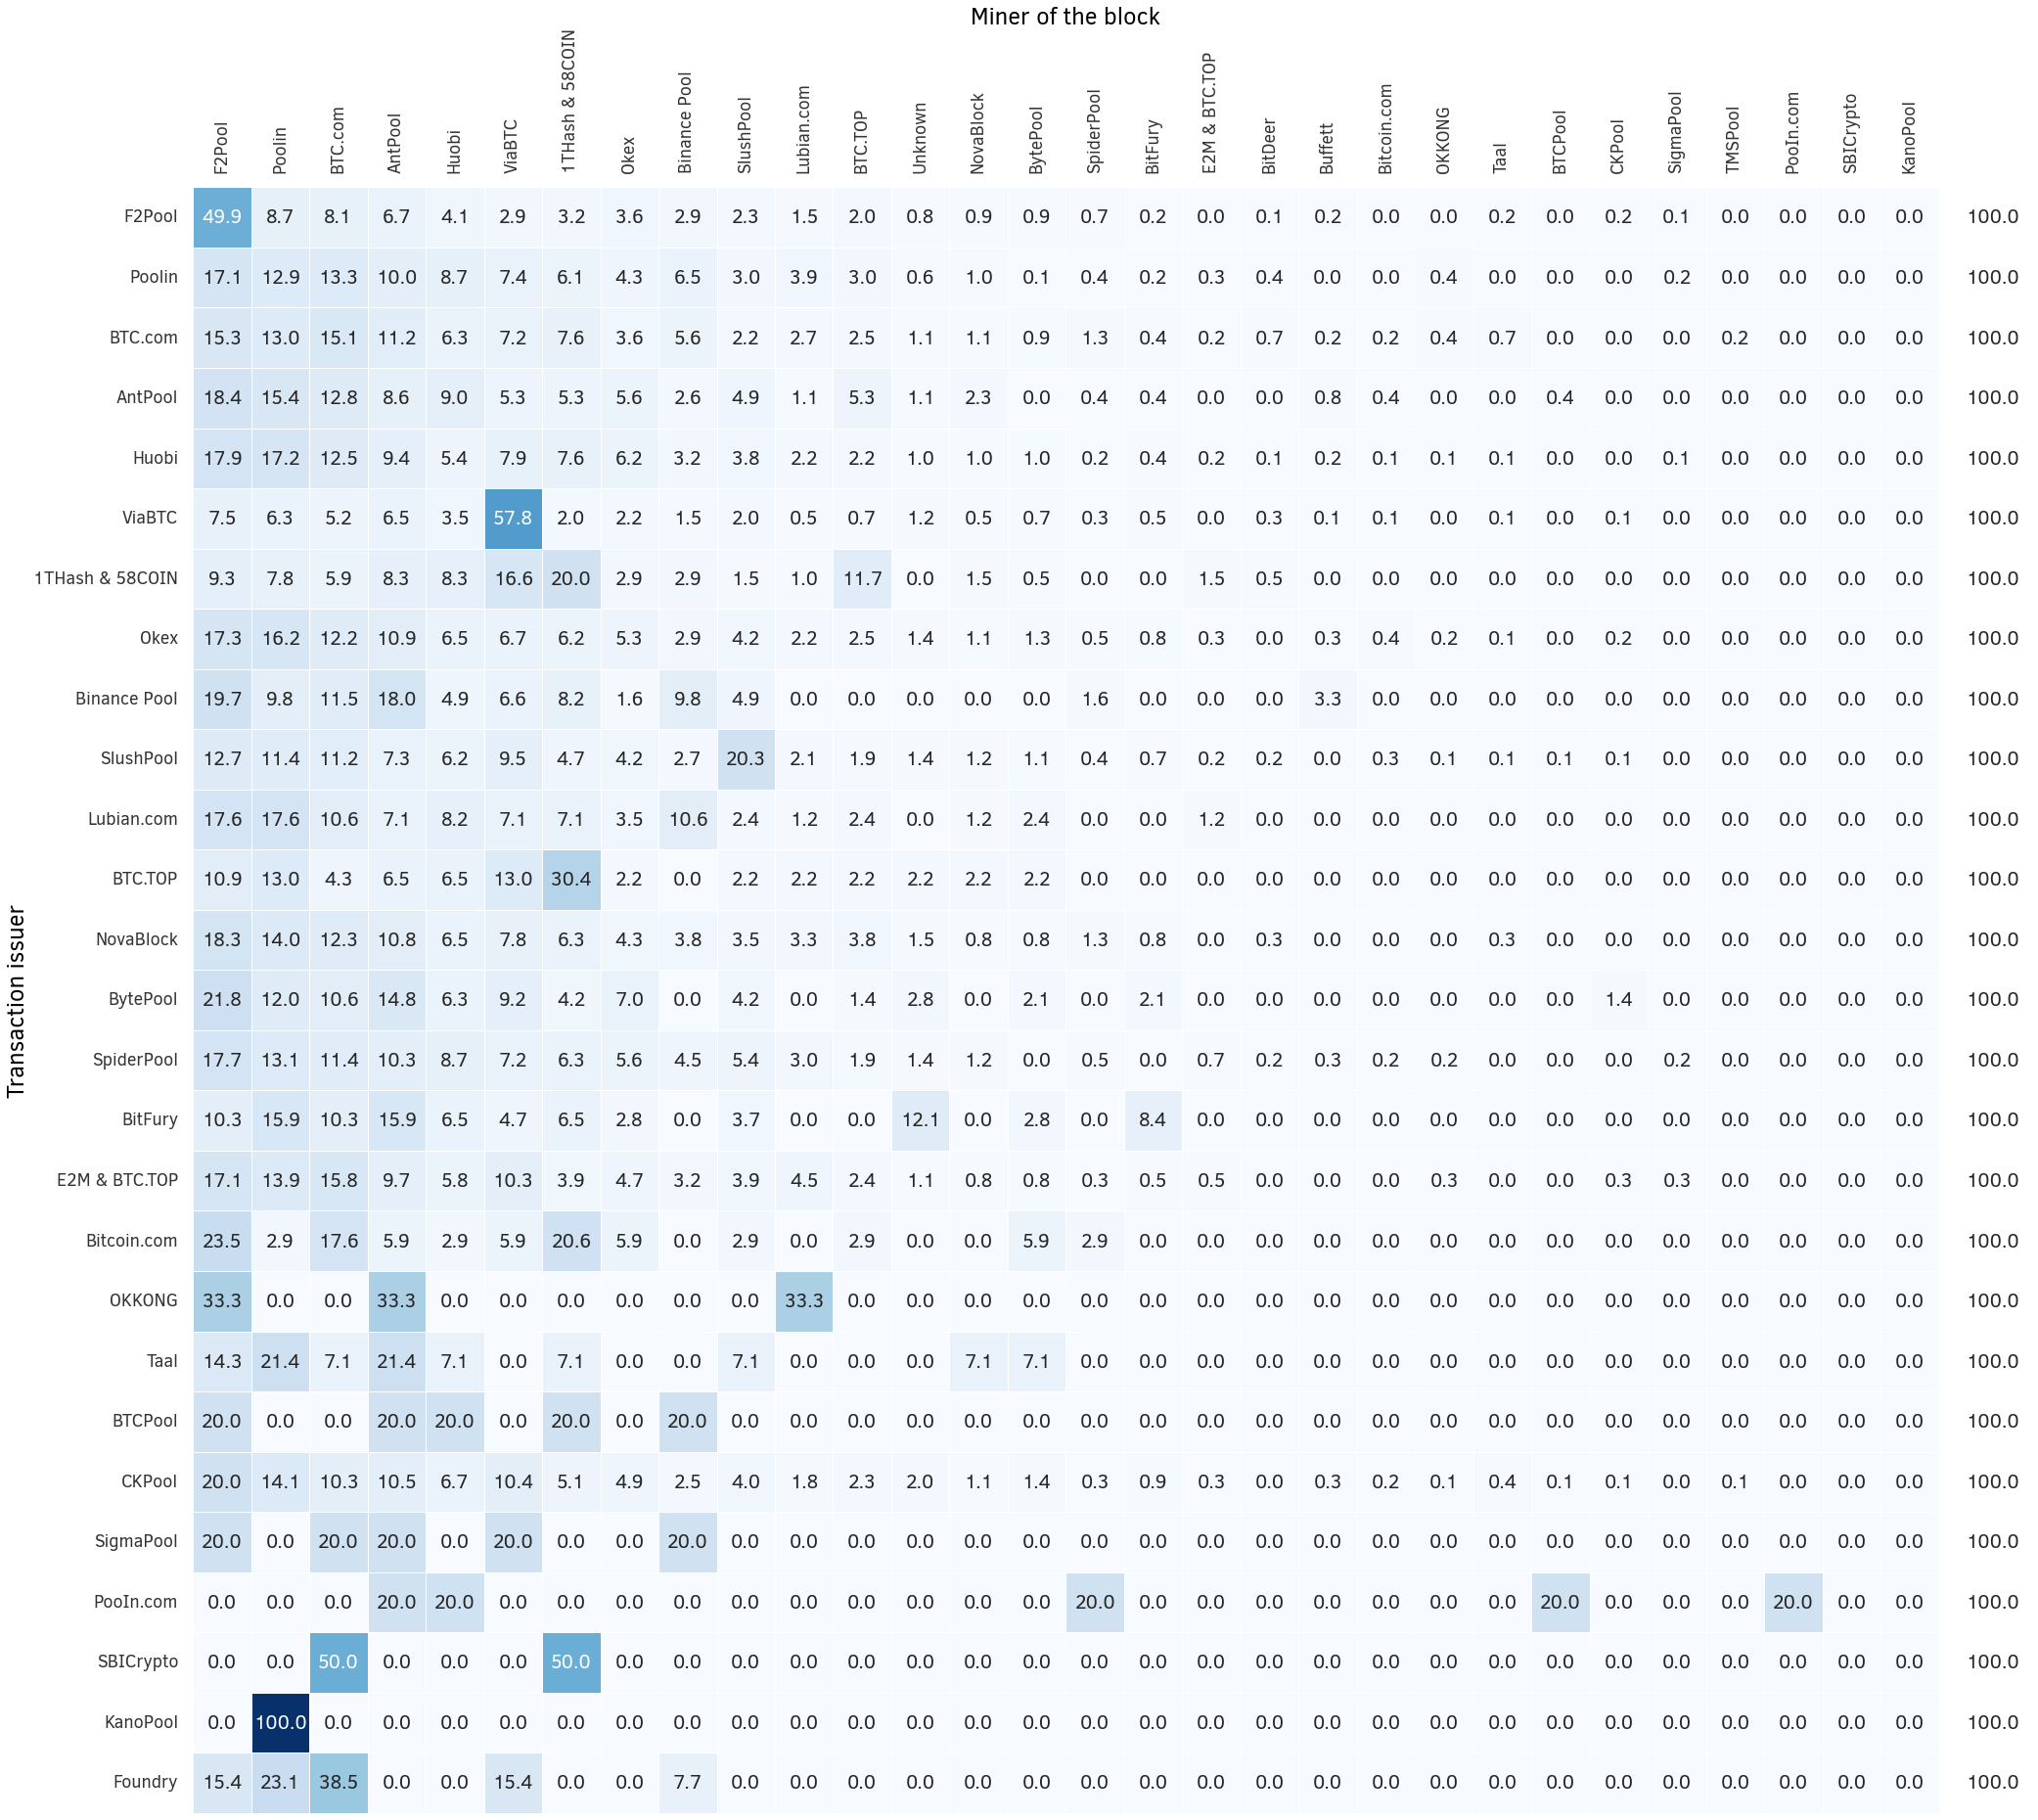

In [79]:
data = mpo_owner.query('is_mpo_owner and n_mpo_owner == 1')[['block_height', 'miner', 'mpo_owner']].groupby(['miner', 'mpo_owner']).size().to_frame().reset_index()
data.columns = ['Miner of the block', 'Transaction issuer', 'amount']

d = data.pivot("Transaction issuer", "Miner of the block", "amount").fillna(0)
d = d.loc[[miner for miner in top_miners if miner in d.index]][[miner for miner in top_miners if miner in d.columns]]
d = 100 * d.divide(d.sum(axis=1), axis=0)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot2grid((20, 20), (0, 0), colspan=19, rowspan=19)
# ax2 = plt.subplot2grid((20, 20), (19, 0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20, 20), (0, 19), colspan=1, rowspan=19)
sns.heatmap(d, ax=ax1, annot=True, cmap="Blues", cbar=False, linewidths=.5,fmt='.1f')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xticklabels(d.columns,rotation=90)

sns.heatmap(pd.DataFrame(d.sum(axis=1)), ax=ax3,  annot=True, cmap=ListedColormap(['white']), cbar=False, xticklabels=False, yticklabels=False, fmt='.1f')

ax3.set_ylabel('')
d

## Blocks

Miner of the block,F2Pool,Poolin,BTC.com,AntPool,Huobi,ViaBTC,1THash & 58COIN,Okex,Binance Pool,SlushPool,...,Bitcoin.com,OKKONG,Taal,BTCPool,CKPool,SigmaPool,TMSPool,PooIn.com,SBICrypto,KanoPool
Transaction issuer,,,,,,,,,,,,,,,,,,,,,
F2Pool,466.0,69.0,62.0,50.0,30.0,21.0,25.0,26.0,22.0,17.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
Poolin,317.0,247.0,245.0,193.0,163.0,142.0,120.0,86.0,110.0,52.0,...,0.0,7.0,0.0,1.0,0.0,5.0,1.0,0.0,1.0,1.0
BTC.com,67.0,56.0,66.0,48.0,28.0,31.0,32.0,15.0,24.0,10.0,...,1.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AntPool,49.0,41.0,34.0,22.0,23.0,14.0,14.0,15.0,7.0,13.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Huobi,236.0,221.0,175.0,128.0,78.0,101.0,100.0,80.0,39.0,49.0,...,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ViaBTC,54.0,46.0,38.0,48.0,26.0,412.0,15.0,16.0,11.0,15.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1THash & 58COIN,19.0,16.0,12.0,16.0,17.0,34.0,39.0,6.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Okex,356.0,334.0,251.0,227.0,135.0,136.0,128.0,109.0,60.0,87.0,...,9.0,4.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0
Binance Pool,12.0,6.0,7.0,11.0,3.0,4.0,5.0,1.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


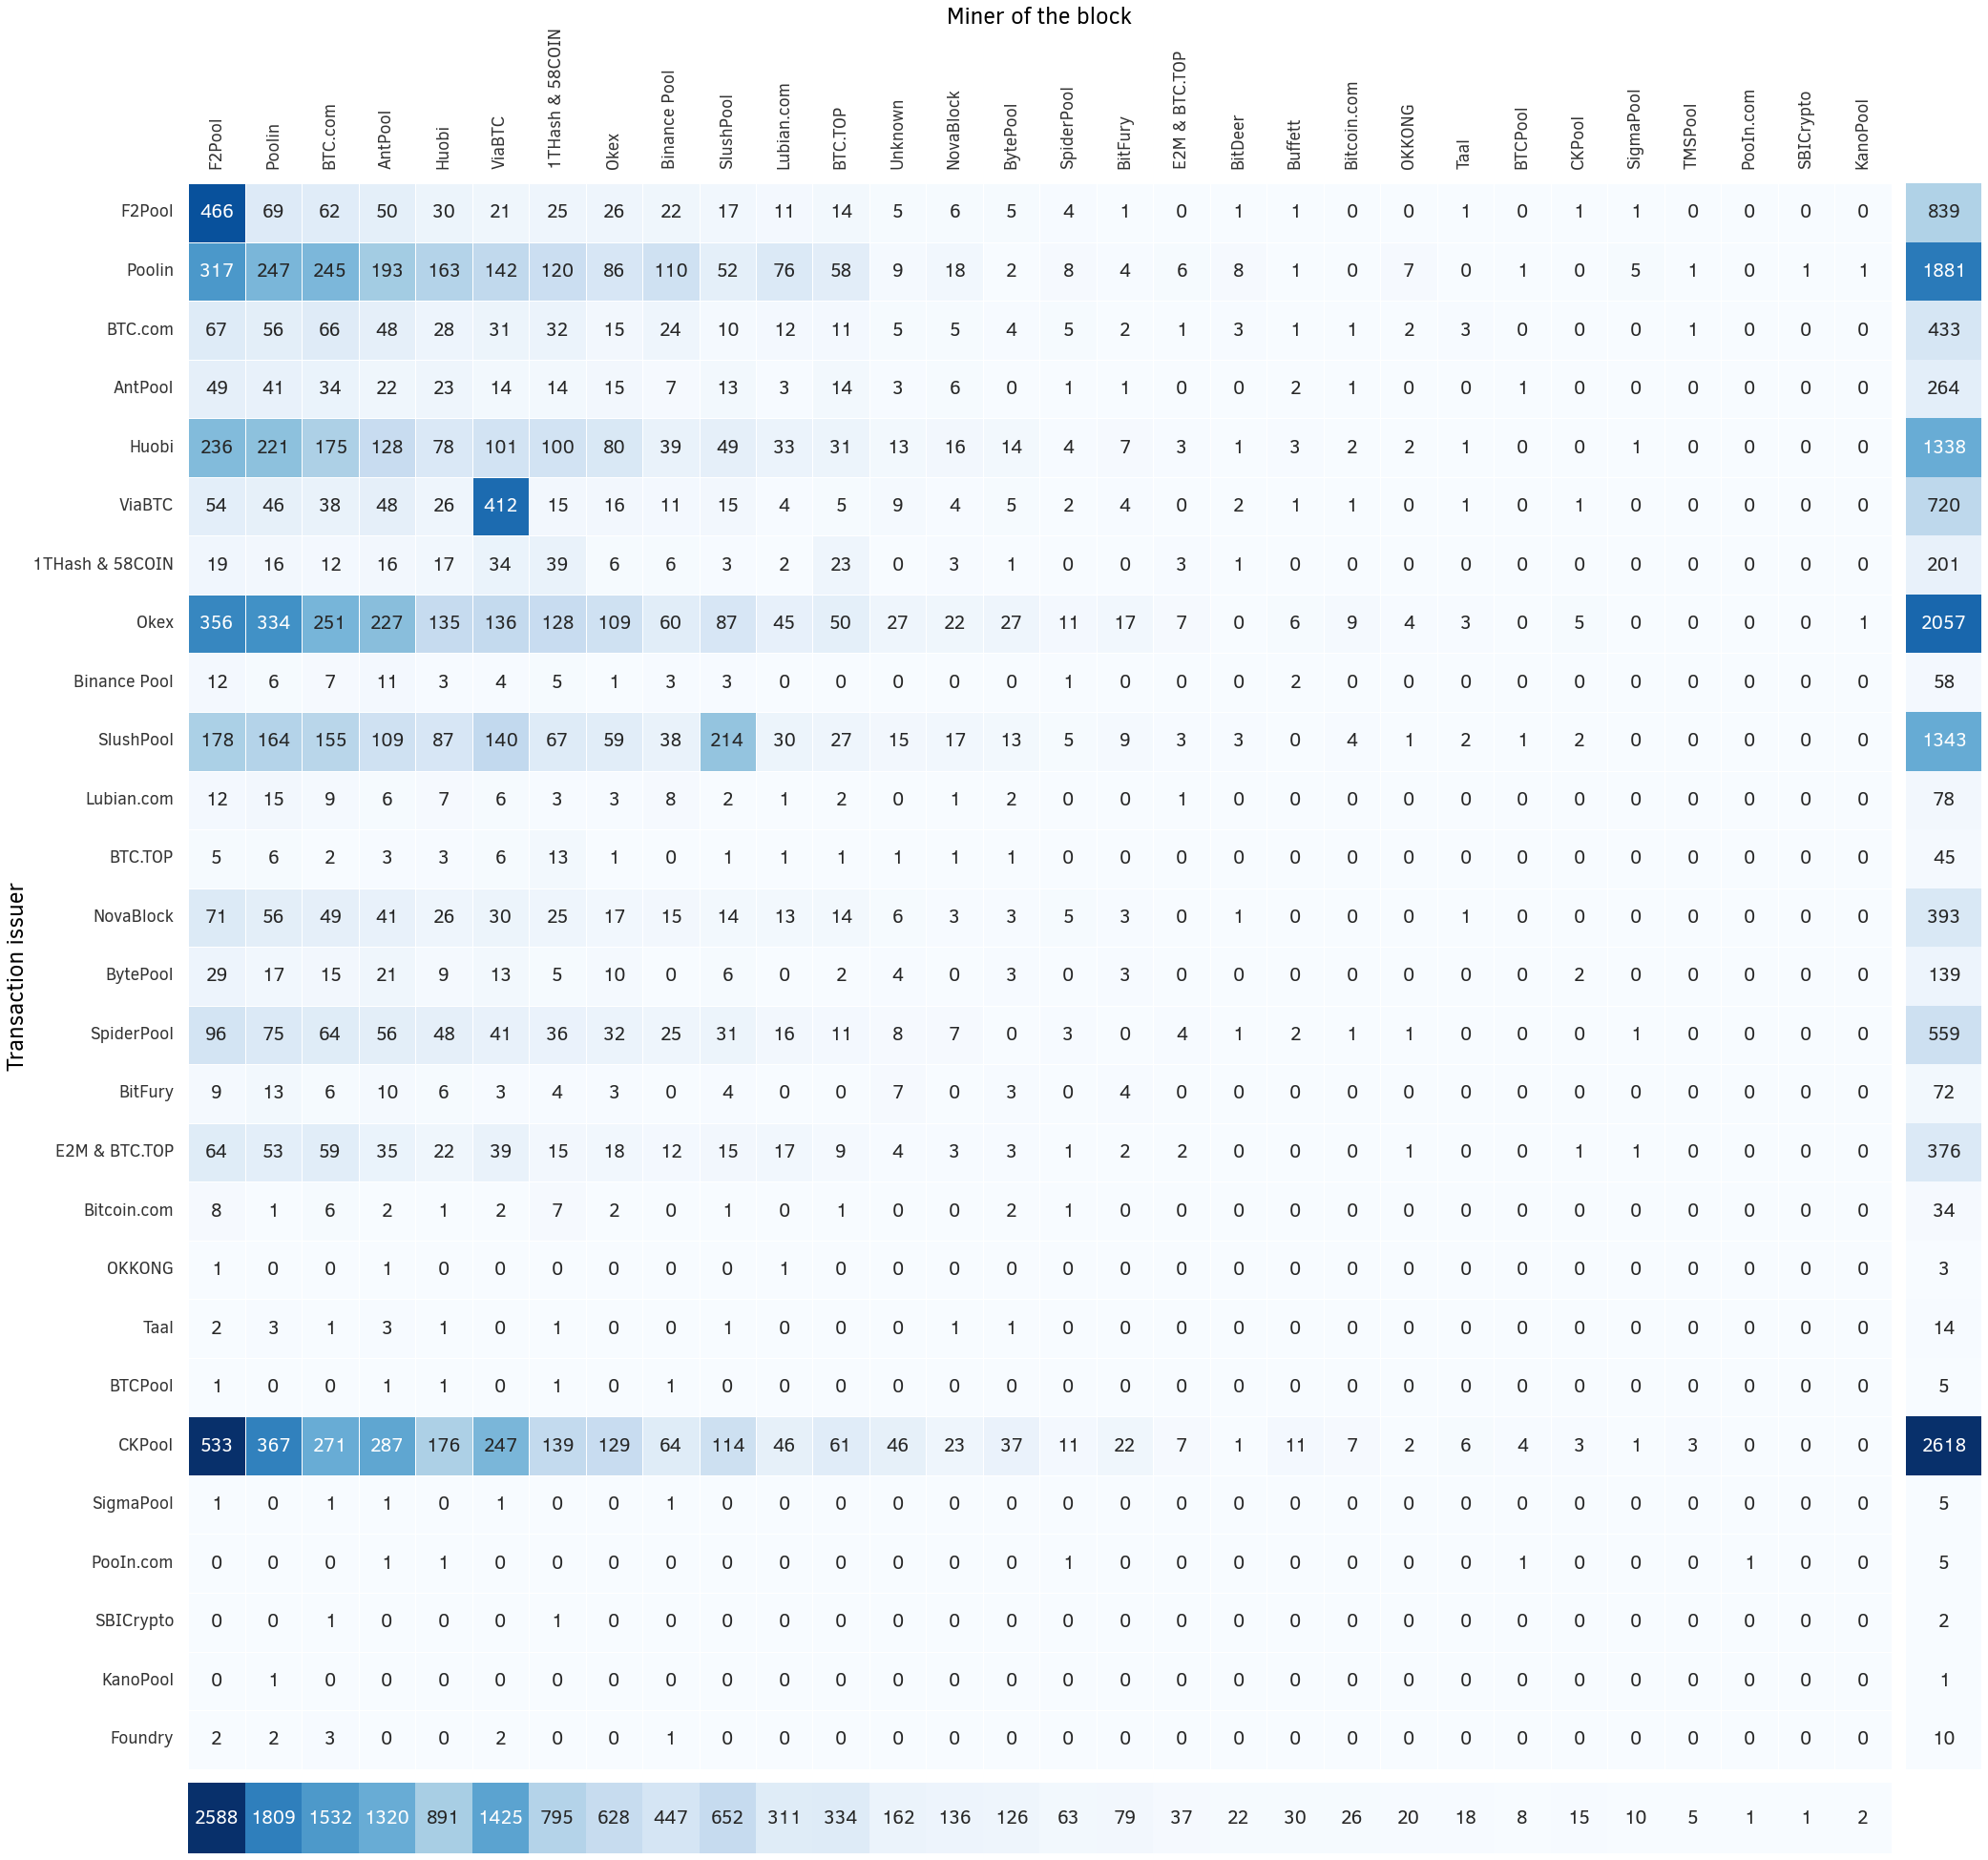

In [80]:
data = mpo_owner.query('is_mpo_owner and n_mpo_owner == 1')[['block_height', 'miner', 'mpo_owner']].drop_duplicates().groupby(['miner', 'mpo_owner']).size().to_frame().reset_index()
data.columns = ['Miner of the block', 'Transaction issuer', 'amount']

d = data.pivot("Transaction issuer", "Miner of the block", "amount").fillna(0)
d = d.loc[[miner for miner in top_miners if miner in d.index]][[miner for miner in top_miners if miner in d.columns]]

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot2grid((20, 20), (0, 0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((20, 20), (19, 0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20, 20), (0, 19), colspan=1, rowspan=19)
sns.heatmap(d, ax=ax1, annot=True, cmap="Blues", cbar=False, linewidths=.5,fmt='g')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xticklabels(d.columns,rotation=90)

sns.heatmap((pd.DataFrame(d.sum(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, fmt='g')
sns.heatmap(pd.DataFrame(d.sum(axis=1)), ax=ax3,  annot=True, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False, fmt='g')

ax2.set_xlabel('')
ax3.set_ylabel('')
d

Miner of the block,F2Pool,Poolin,BTC.com,AntPool,Huobi,ViaBTC,1THash & 58COIN,Okex,Binance Pool,SlushPool,...,Bitcoin.com,OKKONG,Taal,BTCPool,CKPool,SigmaPool,TMSPool,PooIn.com,SBICrypto,KanoPool
Transaction issuer,,,,,,,,,,,,,,,,,,,,,
F2Pool,55.54231228,8.22407628,7.38974970,5.95947557,3.57568534,2.50297974,2.97973778,3.09892729,2.62216925,2.02622169,...,0.00000000,0.00000000,0.11918951,0.00000000,0.11918951,0.11918951,0.00000000,0.0,0.00000000,0.00000000
Poolin,16.85273791,13.13131313,13.02498671,10.26049973,8.66560340,7.54917597,6.37958533,4.57203615,5.84795322,2.76448698,...,0.00000000,0.37214248,0.00000000,0.05316321,0.00000000,0.26581606,0.05316321,0.0,0.05316321,0.05316321
BTC.com,15.47344111,12.93302540,15.24249423,11.08545035,6.46651270,7.15935335,7.39030023,3.46420323,5.54272517,2.30946882,...,0.23094688,0.46189376,0.69284065,0.00000000,0.00000000,0.00000000,0.23094688,0.0,0.00000000,0.00000000
AntPool,18.56060606,15.53030303,12.87878788,8.33333333,8.71212121,5.30303030,5.30303030,5.68181818,2.65151515,4.92424242,...,0.37878788,0.00000000,0.00000000,0.37878788,0.00000000,0.00000000,0.00000000,0.0,0.00000000,0.00000000
Huobi,17.63826607,16.51718984,13.07922272,9.56651719,5.82959641,7.54857997,7.47384155,5.97907324,2.91479821,3.66218236,...,0.14947683,0.14947683,0.07473842,0.00000000,0.00000000,0.07473842,0.00000000,0.0,0.00000000,0.00000000
ViaBTC,7.50000000,6.38888889,5.27777778,6.66666667,3.61111111,57.22222222,2.08333333,2.22222222,1.52777778,2.08333333,...,0.13888889,0.00000000,0.13888889,0.00000000,0.13888889,0.00000000,0.00000000,0.0,0.00000000,0.00000000
1THash & 58COIN,9.45273632,7.96019900,5.97014925,7.96019900,8.45771144,16.91542289,19.40298507,2.98507463,2.98507463,1.49253731,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.00000000,0.00000000
Okex,17.30675741,16.23723870,12.20223627,11.03548858,6.56295576,6.61157025,6.22265435,5.29897910,2.91686923,4.22946038,...,0.43753038,0.19445795,0.14584346,0.00000000,0.24307244,0.00000000,0.00000000,0.0,0.00000000,0.04861449
Binance Pool,20.68965517,10.34482759,12.06896552,18.96551724,5.17241379,6.89655172,8.62068966,1.72413793,5.17241379,5.17241379,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.00000000,0.00000000


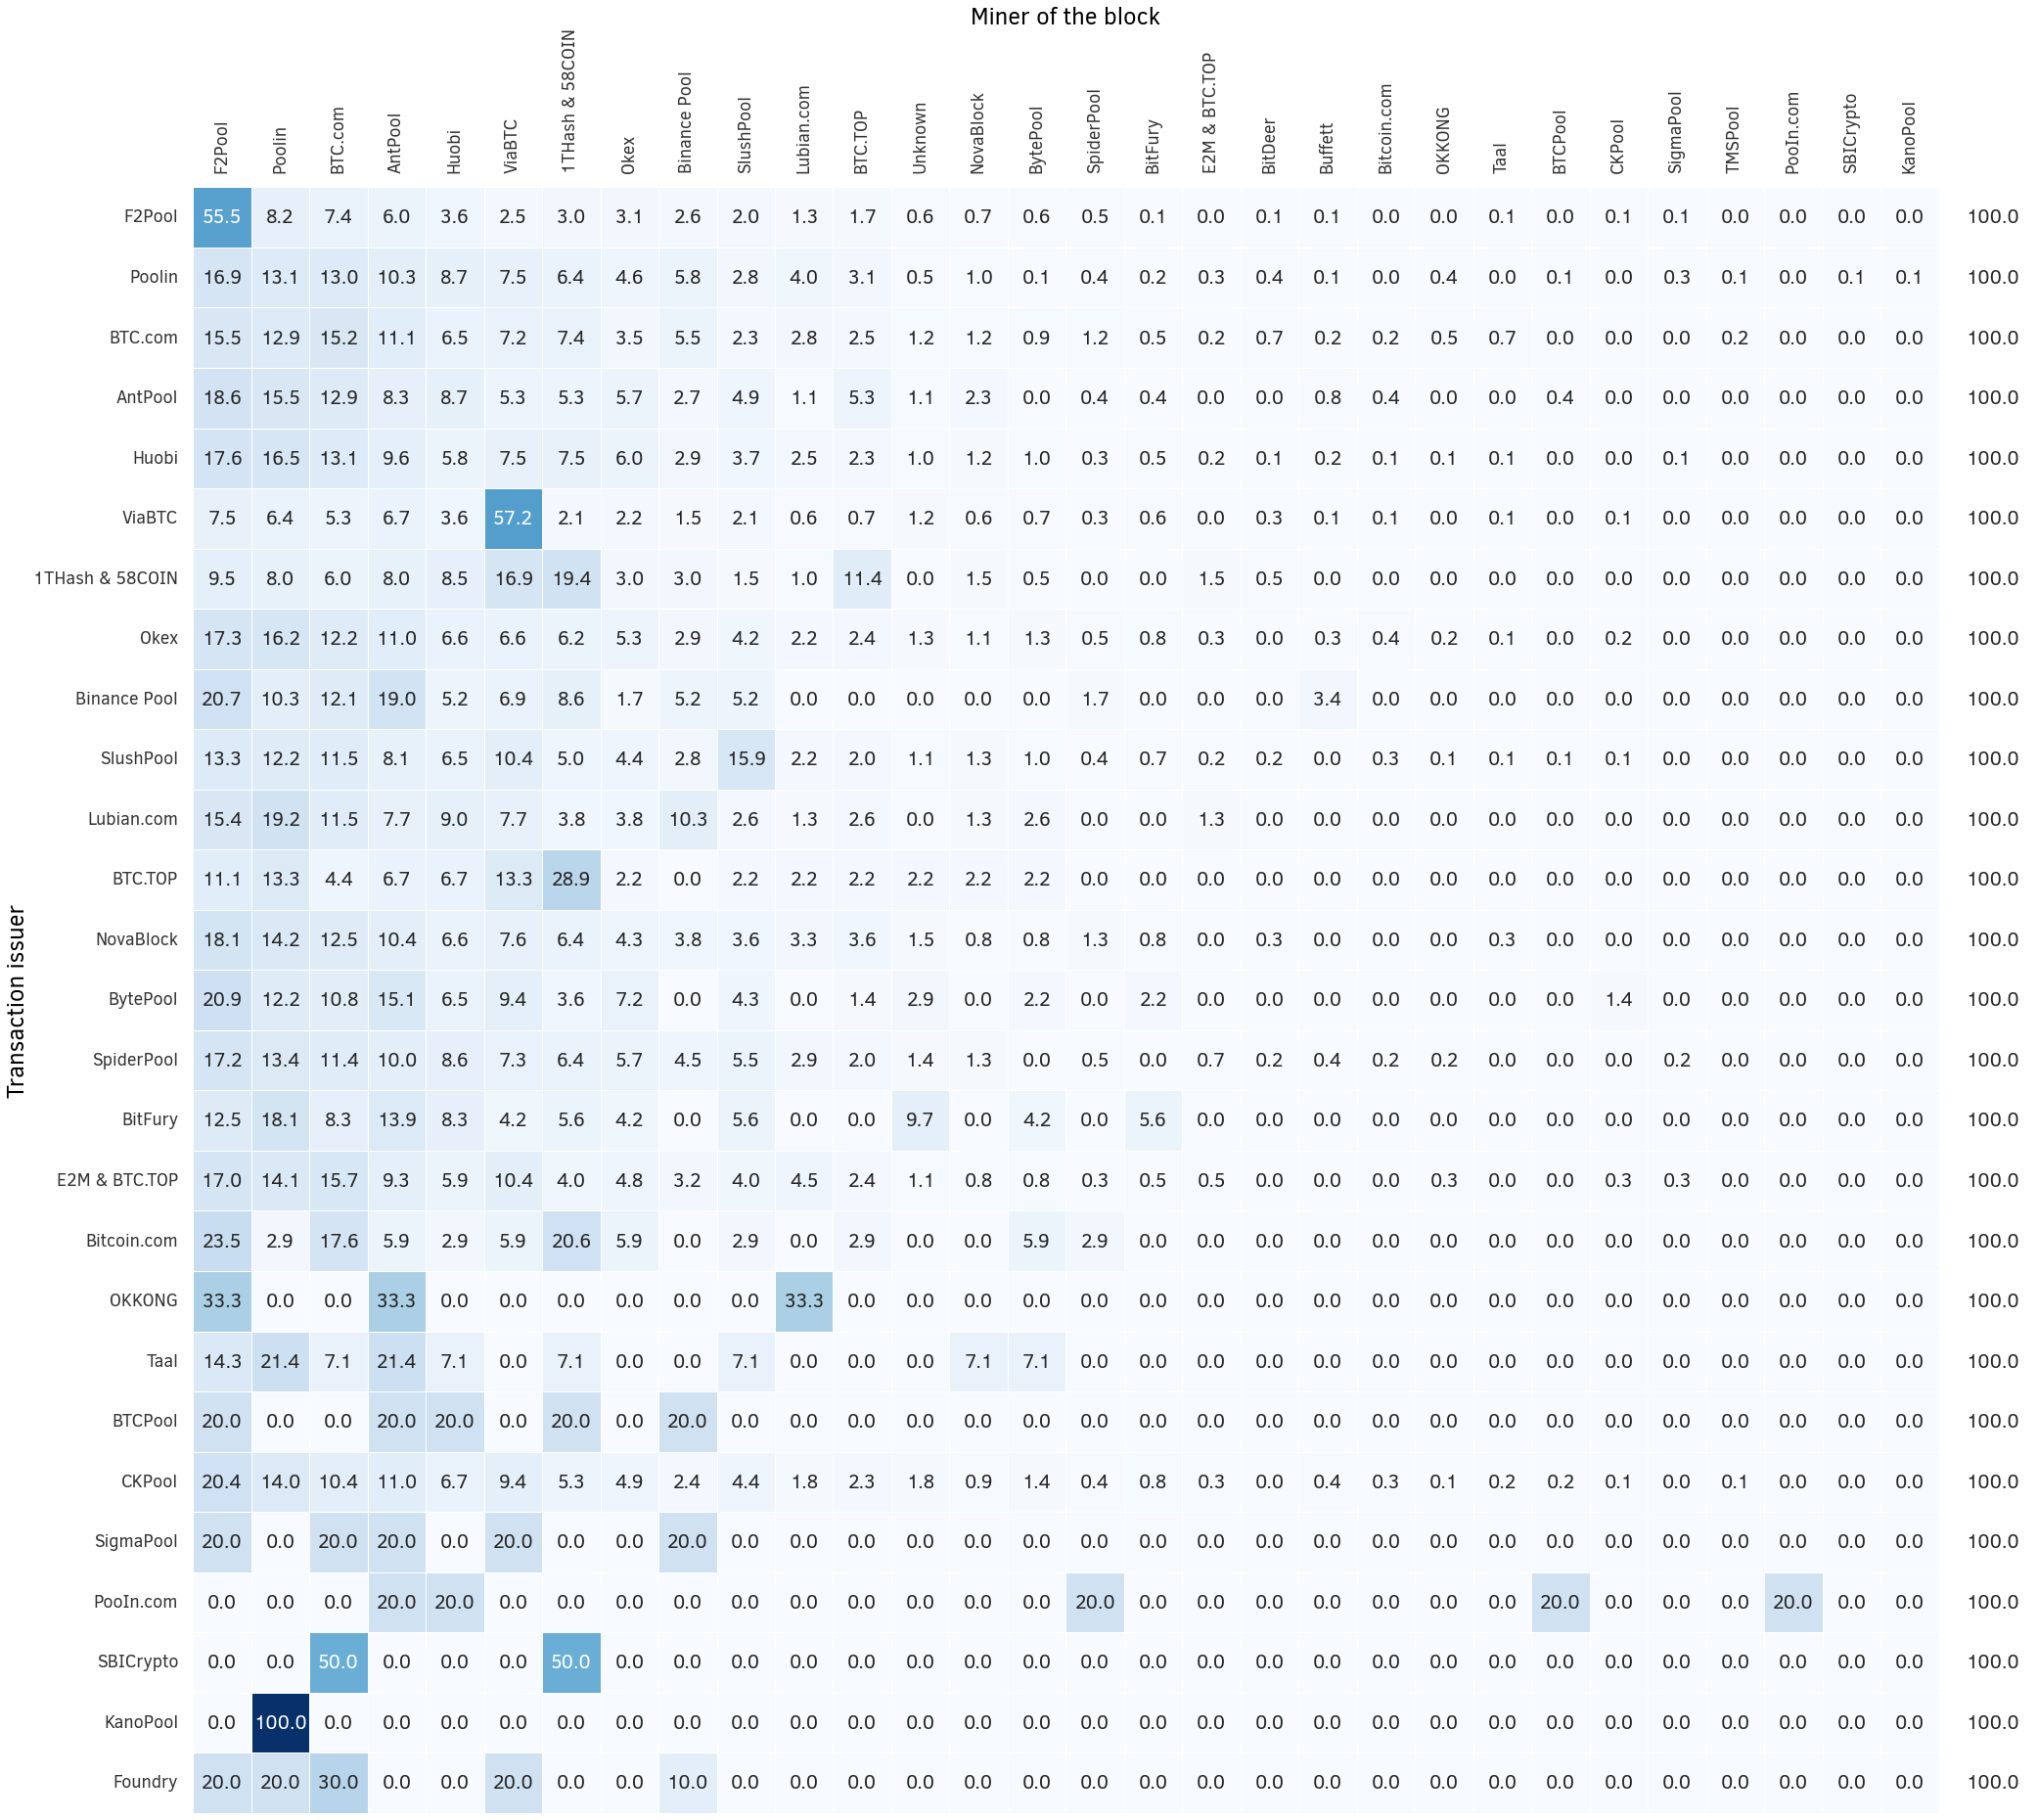

In [81]:
data = mpo_owner.query('is_mpo_owner and n_mpo_owner == 1')[['block_height', 'miner', 'mpo_owner']].drop_duplicates().groupby(['miner', 'mpo_owner']).size().to_frame().reset_index()
data.columns = ['Miner of the block', 'Transaction issuer', 'amount']

d = data.pivot("Transaction issuer", "Miner of the block", "amount").fillna(0)
d = d.loc[[miner for miner in top_miners if miner in d.index]][[miner for miner in top_miners if miner in d.columns]]
d = 100 * d.divide(d.sum(axis=1), axis=0)

fig = plt.figure(figsize=(30, 30))
ax1 = plt.subplot2grid((20, 20), (0, 0), colspan=19, rowspan=19)
# ax2 = plt.subplot2grid((20, 20), (19, 0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20, 20), (0, 19), colspan=1, rowspan=19)
sns.heatmap(d, ax=ax1, annot=True, cmap="Blues", cbar=False, linewidths=.5,fmt='.1f')
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xticklabels(d.columns,rotation=90)

sns.heatmap(pd.DataFrame(d.sum(axis=1)), ax=ax3,  annot=True, cmap=ListedColormap(['white']), cbar=False, xticklabels=False, yticklabels=False, fmt='.1f')

ax3.set_ylabel('')
d